# The Devil Wears Gold

Most of us, if not all of us, like gold. It's shiny, it's beautiful, it's luxurious, it's worth a lot. But, it's quite common knowledge that obtaining high-quality gold isn't easy, and there must be some reason why it is so expensive. The process in which raw, freshly-mined gold is being purified and stripped of its impurities is our main topic in this study. Rather, we have been tasked with obtaining a model which can predict the percentage of gold recovery from the said process, given all kinds of gold-ore parameters.

# Outline of Actions
This is quite a long study. These are the main steps which will be performed:

1) Exploration of the data. We are going to look what each dataset contains, and what are the differences between all the sets. We are going to explain these differences. We will also make sure that some of the calculations in the data were performed correctly, in order to verify its correctness. After that, we are going to fill the missing values.

2) A more in-depth analysis of the data will take place. Our main goal here is to detect anomalies, but we might also learn a thing or two about the process itself. Once anomalies will be found, we will discuss how to deal with them, and act accordingly.

3) After our data will be cleaned, we will start preparing it for model-training. We will slice and prepare the necessary features, and then start experimenting with models in order to see which one can give us the best predictive results. Our search for the best model will be assisted by GridSearchCV. The metric for evaluating the models will also be discussed. Finally, after the best model will be found, we will test it using an "unseen" dataset, and use our evaluation metric to measure its quality. We will then compare it to a "dummy" model which always predicts the same values - we want to see if our model does a better job than the dummy model, and let's just say that we didn't mention the Devil in the project's name for nothing...

Fair warning - you're in for a lot of reading.

# Table of Contents

1. [Initialization](#Initialization) 
2. [Looking at the Datasets](#Looking-at-the-Datasets)

    2.1 [The Train Data](#The-Train-Data)
    
    2.2 [The Test Data](#The-Test-Data)
    
    2.3 [The Full Data](#The-Full-Data)
    
3. [Verifying Recovery Calculations](#Verifying-Recovery-Calculations)

4. [A Word About Missing Values](#A-Word-About-Missing-Values)

5. [Filling the Missing Values](#Filling-the-Missing-Values)

6. [Analyzing the Data](#Analyzing-the-Data)

    6.1 [Changes in Metal Concentrations Between Steps](#Changes-in-Metal-Concentrations-Between-Steps)
    
    6.2 [Anomalies](#Anomalies)
    
    6.3 [Dealing With Anomalies](#Dealing-With-Anomalies)
    
    6.4 [Feed Particle Size Comparison](#Feed-Particle-Size-Comparison)
    
7. [Experimenting With Models](#Experimenting-With-Models)

    7.1 [RandomForestRegressor](#RandomForestRegressor)
    
    7.2 [Linear Regression](#Linear-Regression)

8. [Testing the Model](#Testing-the-Model)

9. [Sanity Check](#Sanity-Check)

# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error as mae
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading the data
# note, the datatype for the `date` column was changed from `object` to `datetime64`.
gold_recovery_train_raw = pd.read_csv('gold_recovery_train.csv', parse_dates=['date'],)
gold_recovery_test_raw = pd.read_csv('gold_recovery_test.csv', parse_dates=['date'],)
gold_recovery_full_raw = pd.read_csv('gold_recovery_full.csv', parse_dates=['date'],)

## Looking at the Datasets
We have three separate datasets, though it is hinted they are somehow connected. We are going to look into each one of them for length, duplicates, missing values, number of columns, etc.

### The Train Data

In [3]:
# first look
gold_recovery_train_raw.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
gold_recovery_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                16860 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         16788 non-null  float64       
 2   final.output.concentrate_pb                         16788 non-null  float64       
 3   final.output.concentrate_sol                        16490 non-null  float64       
 4   final.output.concentrate_au                         16789 non-null  float64       
 5   final.output.recovery                               15339 non-null  float64       
 6   final.output.tail_ag                                16794 non-null  float64       
 7   final.output.tail_pb                                16677 non-null  float64       
 8   final.

In [5]:
# checking for duplicates in the `date` column
print ('Number of duplicates in `date` column:', gold_recovery_train_raw['date'].duplicated().sum())

Number of duplicates in `date` column: 0


In [6]:
# checking for implicit duplicates (identical values across ALL columns, except `date`):
temp = gold_recovery_train_raw.copy()
temp.drop(['date'], axis = 1)
temp.duplicated().sum()

0

- The `train` dataset has 87 columns, most of which have missing values, which we will have to take care of later.
- The data seems to be *sequential*, meaning there is some significance to the order of the observations - they are connected, not independant.
- There are no duplicates in the `date` column. That would mean there are no duplicate rows at all. Though unlikely anyway, we also made sure there aren't any implicit duplicates - meaning, observations with identical values across *all* columns, except the date. We wanted to be on the safe side on this one.

### The Test Data

In [7]:
# first look
gold_recovery_test_raw.head(5)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [8]:
gold_recovery_test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5554 non-null   float64       
 2   primary_cleaner.input.depressant            5572 non-null   float64       
 3   primary_cleaner.input.feed_size             5856 non-null   float64       
 4   primary_cleaner.input.xanthate              5690 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64       
 9   primary_

In [9]:
# checking for duplicates in the `date` column
print ('Number of duplicates in `date` column:', gold_recovery_test_raw['date'].duplicated().sum())

Number of duplicates in `date` column: 0


In [10]:
# checking for implicit duplicates (identical values across ALL columns, except `date`):
temp = gold_recovery_test_raw.copy()
temp.drop(['date'], axis = 1)
temp.duplicated().sum()

0

- The `test` dataset has 53 columns (which is quite a lot less than the training set) most of which have missing values, which we will have to take care of later.
- Here too the data seems to be sequential.
- There are no duplicates, as was made sure by the same method we used with the train data.

What catches the eye the most is that the test data has much less columns (34, to be precise). There must be a reason for that, but it will help if we knew what these columns were:

In [11]:
# checking the names of the training-only columns:
set(gold_recovery_train_raw.columns) - set(gold_recovery_test_raw.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

It looks like the test set only contains the features which will be available to the model, at the time of making predictions. The training data contains features (and targets) that we cannot have at the time of making predictions - things like final output concentrations of different metals after the entire process, as well as intermediate outputs of said metals (these are what we need to predict), as well as other parameters like amounts of different reagents, and all kinds of calculated properties.

In other words - the "missing" features in our test set are all kinds of *outputs* (that's the keyword) - features that we can only know after the technological process takes place, not before. These are not features the model can have at the time of prediction. Other features are simply calculations we can do after the process is done. 

Naturally, since this is a test dataset, it doesn't have the target values we need to predict - which are `rougher.output.recovery` and `final.output.recovery`.

In conclusion, our *training* data contains all the features we need for model-building plus some extra features that we don't, since they are either irrelevant and/or can only be found out after the chemical process is complete, and we cannot know them at the time of prediction, which is why they are missing from the test set. As we will explain later, these "extra" features will have to be removed when we start training our models.

### The Full Data

In [12]:
# first look
gold_recovery_full_raw.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [13]:
gold_recovery_full_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22627 non-null  float64       
 2   final.output.concentrate_pb                         22629 non-null  float64       
 3   final.output.concentrate_sol                        22331 non-null  float64       
 4   final.output.concentrate_au                         22630 non-null  float64       
 5   final.output.recovery                               20753 non-null  float64       
 6   final.output.tail_ag                                22633 non-null  float64       
 7   final.output.tail_pb                                22516 non-null  float64       
 8   final.

In [14]:
# checking for duplicates in the `date` column
print ('Number of duplicates in `date` column:', gold_recovery_full_raw['date'].duplicated().sum())

Number of duplicates in `date` column: 0


In [15]:
# checking for implicit duplicates (identical values across ALL columns, except `date`):
temp = gold_recovery_full_raw.copy()
temp.drop(['date'], axis = 1)
temp.duplicated().sum()

0

In [16]:
# Checking the date spans of all the datasets
print ('Training set date span:')
print ('Start date:', gold_recovery_train_raw['date'].min())
print ('End date:', gold_recovery_train_raw['date'].max())
print ()
print ('Test set date span:')
print ('Start date:', gold_recovery_test_raw['date'].min())
print ('End date:', gold_recovery_test_raw['date'].max())
print ()
print ('Full set date span:')
print ('Start date:', gold_recovery_full_raw['date'].min())
print ('End date:', gold_recovery_full_raw['date'].max())

Training set date span:
Start date: 2016-01-15 00:00:00
End date: 2018-08-18 10:59:59

Test set date span:
Start date: 2016-09-01 00:59:59
End date: 2017-12-31 23:59:59

Full set date span:
Start date: 2016-01-15 00:00:00
End date: 2018-08-18 10:59:59


- The full data set is comprised of both the training and test datasets (there are no duplicate dates, the lengths of the datasets add up perfectly), but it does seem to be a *retrospective* data - seeing as observations which were only present in the `test` set now have values in training-set-only features filled in them (87 columns), at least to some extent, and **that includes the final targets our model should predict.** 

- In other words, the full dataset does NOT contain the exact same amount of missing values as in the training set, plus 5856 missing values in the training-set-only features. The actual number of missing values is a lot lower. 

- There are a fair few missing values in the full set as well. We believe that the only thing we need to take from this retrospective data are the **targets** which we need to predict, in order to evaluate the quality of our models. Nonetheless, we will fill te missing values in this set as well (as will be discussed below), in order to keep consistency with the other two sets, as much as possible.

- Also, as we just made sure, it looks like the test set was taken from a middle period of the full set. Date from September 1st 2016 to December 31st 2017 was made into the test set, without the training-only features and targets, and the rest of the data was made into the training set.

# Verifying Recovery Calculations
We were given the proper way of calculating the `recovery` at the end of the Flotation process (also knowns as the 'Rougher' process). In our training data, we have our two target variables: `rougher.output.recovery` and `final.output.recovery`. Using the corresponding features, we want to make sure these two were calculated correctly. We will do that by calculating these targets *ourselves*, and check the Mean Average Error (MAE) between our calculations and the values provided in the data.

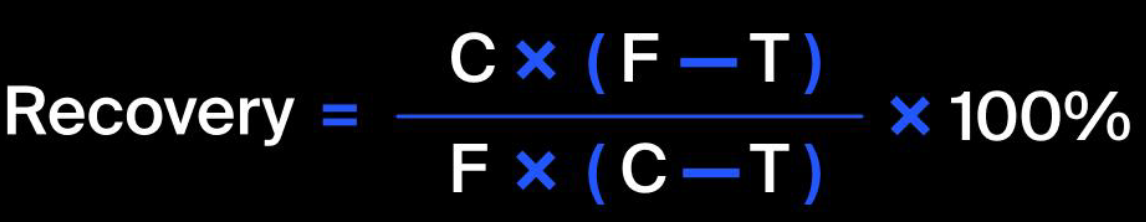

Where:

For `rougher.output.recovery`:

C = share of gold in the **C**oncentrate right after flotation; --> `rougher.output.concentrate_au`

F = share of gold in the **F**eed, right before flotation; --> `rougher.input.feed_au`

T = share of gold in the rougher **T**ails right after flotation. --> `rougher.output.tail_au`

And, for `final.output.recovery`:

C = share of gold in the **C**oncentrate right after purification; --> `final.output.concentrate_au`

F = same as above - share of gold in the **F**eed, right before flotation; --> `rougher.input.feed_au`

T = share of gold in the rougher **T**ails right after purification. --> `final.output.tail_au`

For the sake of the calculations, we will define a new function with the forumla above:

In [17]:
def calc_rougher_recovery (row: pd.Series) -> float:
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    return (100* C*(F-T)) / (F*(C-T))

In [18]:
def calc_final_recovery (row: pd.Series) -> float:
    C = row['final.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['final.output.tail_au']
    return (100* C*(F-T)) / (F*(C-T))

## A Word About Missing Values
Before we do the above calculations, there is something we need to discuss first - the missing values. 

Without knowing why we have them in the first place or if they can be obtained somehow, we have two ways of dealing with them in our current situation:

1) Ignore every observation which contains at least one missing value in any of the three components (C, F or T), OR the recovery result itself (without the latter, we have nothing to compare our results to);

2) Fill the missing values, in one of two ways: 
    
   - Fill with the corresponding column's *mean* value, or
   - Fill with the previous value.
   
Filling missing values is, in general, a way of "guessing" the right values. It is by no means a perfect nor a flawless process. Also it's quite safe to say that in data like ours, the filled-in data will probably never trully match the real values. In addition, right now we only wish to see if the numbers of the `recovery` columns are correct, which means we don't necessarily have to check it on *all* observations - assuming all values in the `recovery` columns were calculated the same way, even if we drop 50% (or more) of our observations, we should still be able to validate the correctness of the data. 

Moreover, if we fill-in the missing values (in either method suggested above) - this could lead to a discrepancy between the real results and the calculated results (for example, we could end up with a result which is lower than 0 or higher than 100 - which is the only logical range for `recovery`), and this might alter our conclusion about the data correctness. Though it is possible that this discrepancy *won't* be significant, we would still like to use only our most reliable data for the sake of this verification.

Let's not forget - some observations could only be missing one out of the four relevant variables. In this case we could, theoretically, fill the missing one by simply solving the equation above for the relevant missing value. That's a lot of work which may not be worthwhile in our case (diminishing returns).
Some other observations, however, could be missing more than one variable - and even be missing all four of them. In that case, filling them up (using either way) will be very unreliable, at least for our current goal. 

All that being said, the obvious conclusion is that we will go with option 1 above. For the sake of the calculations, we will only take observations with all three parameters available to us (no missing values), as well as the result itself (so we can compare it).

**Later, however, when we will need to train models - we will fill the missing data, and hope it won't have any drastic negative impact on our model quality.**

Just to be on the safe side, we will make a copy of the training dataset (only the relevant columns, we don't need all of them), remove all observations with any missing values (we'll check how many of those were dropped), and proceed with the calculations.

In [19]:
# making the necessary subset copy
rougher_recovery = gold_recovery_train_raw[['rougher.output.concentrate_au', 
                                            'rougher.input.feed_au', 
                                            'rougher.output.tail_au', 
                                            'rougher.output.recovery']]

In [20]:
# removing rows with missing values
rougher_recovery.dropna(inplace = True)

In [21]:
# checking for the percentage of preserved rows:
len(rougher_recovery) / len(gold_recovery_train_raw)

0.8473902728351127

We have removed ~15% of observations. The remaining 85% are filled with genuine data, nothing was filled artificially. 

In [22]:
# applying our first function from above, and adding the result to the temporary table
rougher_recovery['calc_recovery'] = rougher_recovery.apply(calc_rougher_recovery, axis = 1)

In [23]:
# checking the result
rougher_recovery.head()

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery,calc_recovery
0,19.793808,6.486150,1.170244,87.107763,87.107763
1,20.050975,6.478583,1.184827,86.843261,86.843261
2,19.737170,6.362222,1.162562,86.842308,86.842308
3,19.320810,6.118189,1.079755,87.226430,87.226430
4,19.216101,5.663707,1.012642,86.688794,86.688794


In [24]:
# calculating MAE. the `mae` function has been imported.
mae(rougher_recovery['rougher.output.recovery'], rougher_recovery['calc_recovery'])

1.1101950495226952e-14

The above result is practically 0. Meaning, there is no discrepancy between our calculataions and the values given in the data. As far as the `rougher.output.recovery` target goes - we are good to go.

Let's also check it for the `final.output.recovery` target as well, just to be sure. The process is identical.

In [25]:
# making the necessary subset copy
final_recovery = gold_recovery_train_raw[['final.output.concentrate_au', 
                                          'rougher.input.feed_au', 
                                          'final.output.tail_au', 
                                          'final.output.recovery']]

In [26]:
# removing rows with missing values
final_recovery.dropna(inplace = True)

In [27]:
# checking for the percentage of preserved rows:
len(final_recovery) / len(gold_recovery_train_raw)

0.9097864768683274

Here we dropped down even less than before - we still have 91% of our data.

In [28]:
# applying our first function from above, and adding the result to the temporary table
final_recovery['calc_recovery'] = final_recovery.apply(calc_final_recovery, axis = 1)

In [29]:
# checking the result
final_recovery.head()

,final.output.concentrate_au,rougher.input.feed_au,final.output.tail_au,final.output.recovery,calc_recovery
0,42.192020,6.486150,2.143149,70.541216,70.541216
1,42.701629,6.478583,2.224930,69.266198,69.266198
2,42.657501,6.362222,2.257889,68.116445,68.116445
3,42.689819,6.118189,2.146849,68.347543,68.347543
4,42.774141,5.663707,2.055292,66.927016,66.927016


In [30]:
# calculating MAE
mae(final_recovery['final.output.recovery'], final_recovery['calc_recovery'])

9.534223885936391e-15

The calculations have been confirmed. We can move on.

# Filling the Missing Values
Now that we are done with checking the calculations, we can finally fill-in the missing values in the data.

Since the data is sequential, there is a meaning to the order of observations. Meaning, they are not independant. While usually missing values can be filled with the mean or median values of the respective column, and that might also be a viable option in our case, we find it more prudent to fill the missing values with the previous value - the `ffill` method. Though it isn't perfect (no method for filling missing values is...), filling with a previous value might be the cloest approximation of the real missing value we can possibly get. 

Since we already know there are no duplicates in the data, filling the missing values is all we are going to do right now, but it doesn't mean we're done. As the study continues, we might find more issues with the data which require fixing.

We are going to fill the missing values in all three datasets - although the main focus is the train and test sets. While we only need the dates and targets from the full dataset, we will fill the missing values just to try to be as consistent as possible with the other two sets.

First, we will eliminate any observations with at least one null *target* value, from the training and full datasets. Missing target values should not be filled.

In [31]:
# creating a copy of the datasets and removing empty target values
gold_recovery_train_new = gold_recovery_train_raw.copy()
gold_recovery_train_new.dropna(subset = 
                               ['rougher.output.recovery','final.output.recovery'], inplace = True)

gold_recovery_full_new = gold_recovery_full_raw.copy()
gold_recovery_full_new.dropna(subset = 
                              ['rougher.output.recovery','final.output.recovery'], inplace = True)

# verifying that no missing target values are left, and checking the % of observations left
print ('Training set:')
print (gold_recovery_train_new[['rougher.output.recovery','final.output.recovery']].isnull().sum())
print ('% observations left: {:.2%}'.format(len(gold_recovery_train_new) / len(gold_recovery_train_raw)))
print ()

print ('Full set:')
print (gold_recovery_full_new[['rougher.output.recovery','final.output.recovery']].isnull().sum())
print ('% observations left: {:.2%}'.format(len(gold_recovery_full_new) / len(gold_recovery_full_raw)))

Training set:
rougher.output.recovery    0
final.output.recovery      0
dtype: int64
% observations left: 83.92%

Full set:
rougher.output.recovery    0
final.output.recovery      0
dtype: int64
% observations left: 85.57%


One more thing we want to check - did those observations with missing target values had missing values in other features? We will count the *total* number of missing values in the datasets, regardless of which features they were in, before and after the above removal.

In [32]:
# checking for the total number of missing values, before and after the removal of the above observations:
print ('BEFORE: missing values counter, train set:', gold_recovery_train_raw.isnull().sum().sum())
print ('AFTER:  missing values counter, train set:', gold_recovery_train_new.isnull().sum().sum())
print ()
print ('BEFORE: missing values counter, full set:', gold_recovery_full_raw.isnull().sum().sum())
print ('AFTER:  missing values counter, full set:', gold_recovery_full_new.isnull().sum().sum())

BEFORE: missing values counter, train set: 30320
AFTER:  missing values counter, train set: 4100

BEFORE: missing values counter, full set: 36587
AFTER:  missing values counter, full set: 4481


In [33]:
# let's have another look at the info of the new training data
gold_recovery_train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14149 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         14148 non-null  float64       
 2   final.output.concentrate_pb                         14148 non-null  float64       
 3   final.output.concentrate_sol                        13938 non-null  float64       
 4   final.output.concentrate_au                         14149 non-null  float64       
 5   final.output.recovery                               14149 non-null  float64       
 6   final.output.tail_ag                                14149 non-null  float64       
 7   final.output.tail_pb                                14049 non-null  float64       
 8   final.

Wow, the majority of null values were taken care of without us even trying too hard. **Apparently, many missing values were in those very same observations which had missing targets values.**

For the remaining observations, none of which has null targets now, we will fill the missing values as discussed.

We will also fill the missing values in the test set, which has no targets.

In [34]:
gold_recovery_train_new.fillna(method = 'ffill', inplace = True)
print ('Missing values counter, train set:', gold_recovery_train_new.isnull().sum().sum())

gold_recovery_full_new.fillna(method = 'ffill', inplace = True)
print ('Missing values counter, full set:', gold_recovery_train_new.isnull().sum().sum())

Missing values counter, train set: 0
Missing values counter, full set: 0


Now we do the same with the test set:

In [35]:
gold_recovery_test_new = gold_recovery_test_raw.copy()
gold_recovery_test_new.fillna(method = 'ffill', inplace = True)
print ('BEFORE: missing values counter, test set:', gold_recovery_test_raw.isnull().sum().sum())
print ('AFTER:  missing values counter, test set:', gold_recovery_test_new.isnull().sum().sum())

BEFORE: missing values counter, test set: 2360
AFTER:  missing values counter, test set: 0


From now, we will be working with the `X_new` dataframes, and will further change them as necessary.

# Analyzing the Data
These are the first two things we need to check:

1) How do the concentrations (%) of the three different metals in question - Gold (Au), Silver (Ag) and Lead (Pb) - change between the entire purification process steps. This means:

- Before flotation (raw feed) - `rougher.input.feed_M`

- After flotation (rougher concentrate) - `rougher.output.concentrate_M`

- After first purification step - `primary_cleaner.output.concentrate_M`

- After second purification step (final concentrate) - `final.output.concentrate_M`

2) Are the feed particle size distributions in the training set and test set more or less identical. 

While we do the above two, we will check for any outliers/anomalies in the data. The visualizations will help us detect those, and then we will have to decide what to do with them. 

## Changes in Metal Concentrations Between Steps

We will visualize the required information using histograms, onto which KDE lines will be added.

We will have three plots, one for each different metal. Each plot will be comprised of four different histograms/KDE lines - each will show the distribution of the given metal's concentration in a specific step.

The three plots will give us information about how each metal's concentration changes with each step of the industrial process. What we want to see is if the gold (Au) concentration is distributed around an increasing percentage value (that's the whole point of the process), with every step of the process. It should be the lowest before flotation and the highest after the second purification.

We would like to see if the opposite occurs with the other metals - that after the final purification step, their concentrations are relatively low to those of the preceding steps.

In addition, we will want to see how the *total concentration* of all three metals change with each step of the process. The gold ore probably contains more components other than just these metals, and we want to see how effective the process is in getting rid of all the "junk". We will add up the concentrations of the metals in each step, and plot yet another histogram-set to see the result. What we hope to see is that with each step, the total concentration of metals is rising.

In [36]:
# setting some themes and properties for the upcoming seaborn plots: 
sns.set(font_scale = 1.5)             # increasing the font sizes a little.
sns.set_style('dark')                 # setting style.
plt.style.use('dark_background')      # setting the seaborn background color to dark.
sns.set_palette('Dark2')              # setting the seaborn color palette.

We are going to need these two lists:

In [37]:
metals = ['au', 'ag', 'pb']
step_headers = ['rougher.input.feed_', 
                'rougher.output.concentrate_', 
                'primary_cleaner.output.concentrate_', 
                'final.output.concentrate_']

In [38]:
def print_hist (metal: str):
    """
    Takes a metal as input, prepares the corresponding list of features, and prints a combined histogram 
    chart for the metal, showing its concentration in each step.
    
    Note: this only works with the `gold_recovery_train_new` dataset!
    """

    columns = [step+metal for step in step_headers]
    ax = sns.displot([gold_recovery_train_new[col] for col in columns], 
                     kind = 'hist', bins = 100, kde = True, edgecolor = 'Black', height = 10, aspect = 2)
    ax.set(title = metal + ' Concentration Per Step', xlabel = 'Percentage')
    sns.move_legend(ax, "upper right", bbox_to_anchor=(0.8, 1.0))

The function is ready. Let's plot!

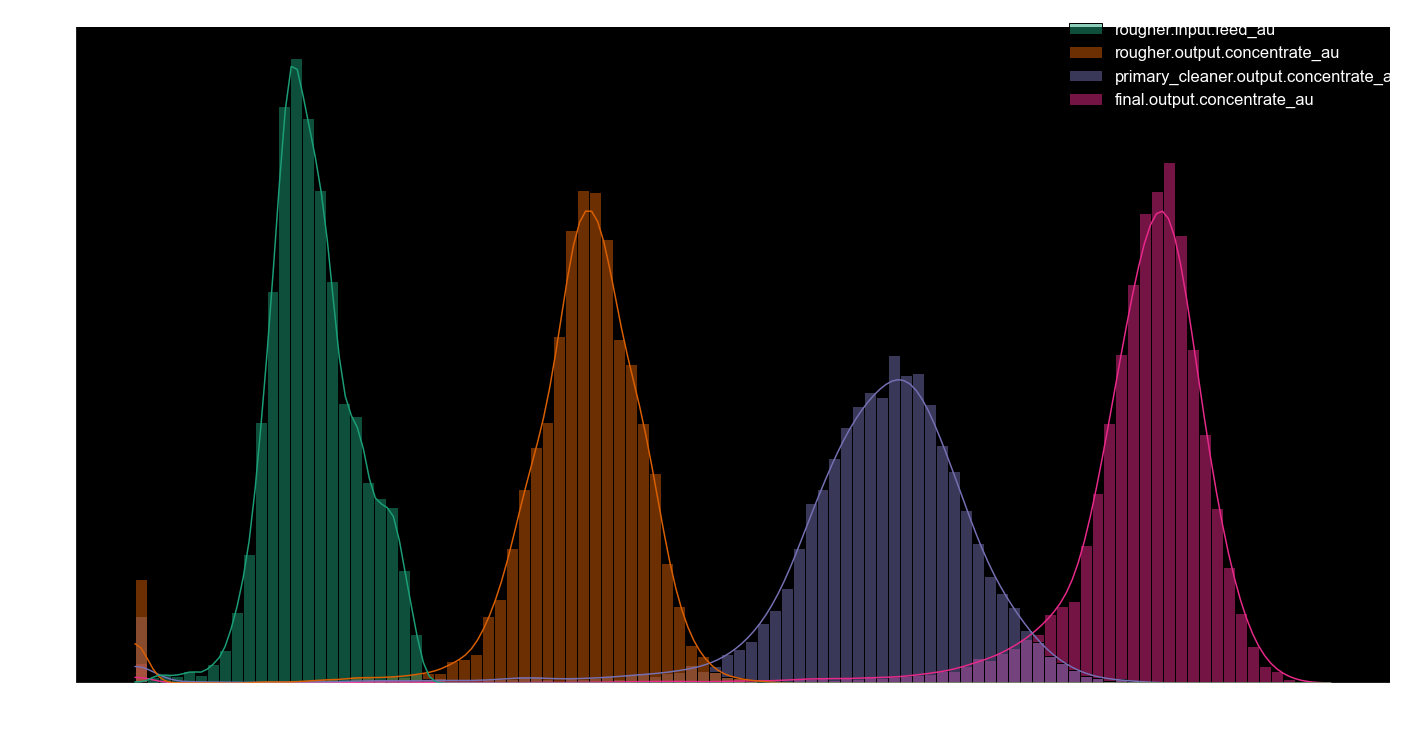

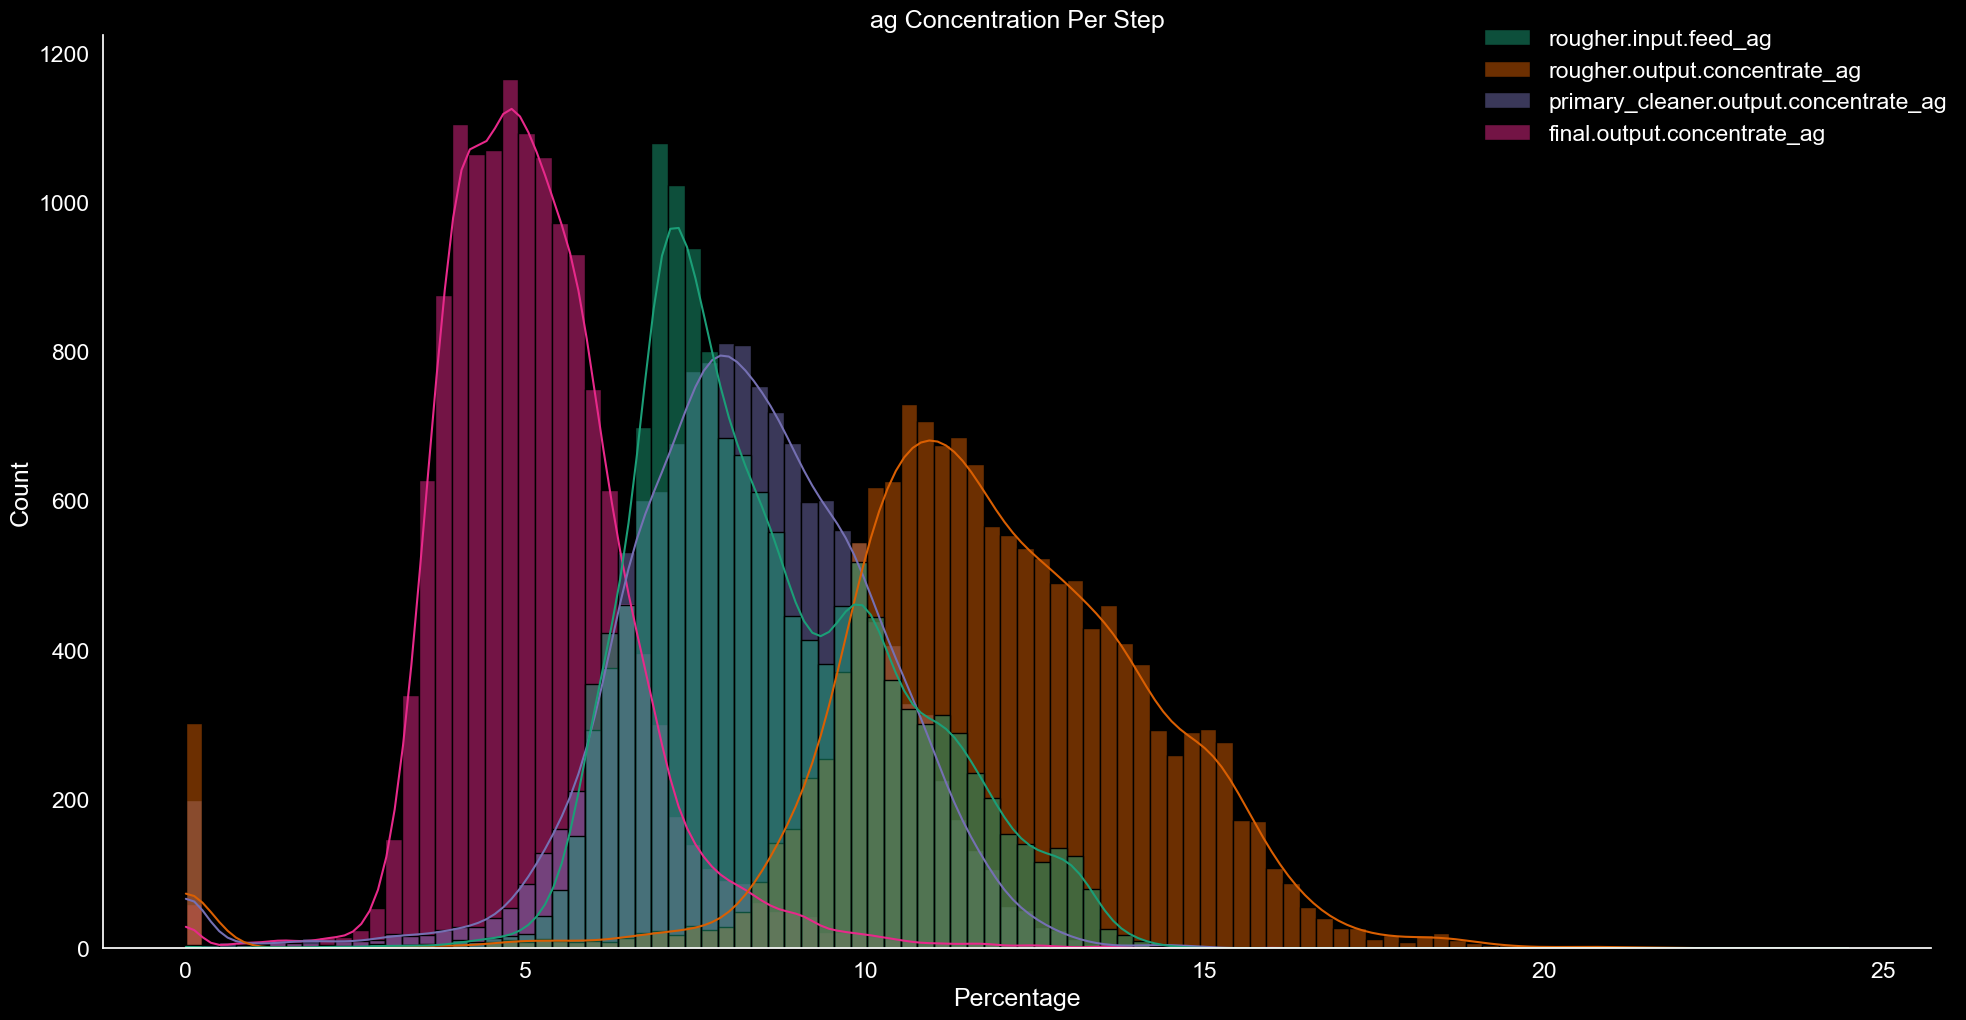

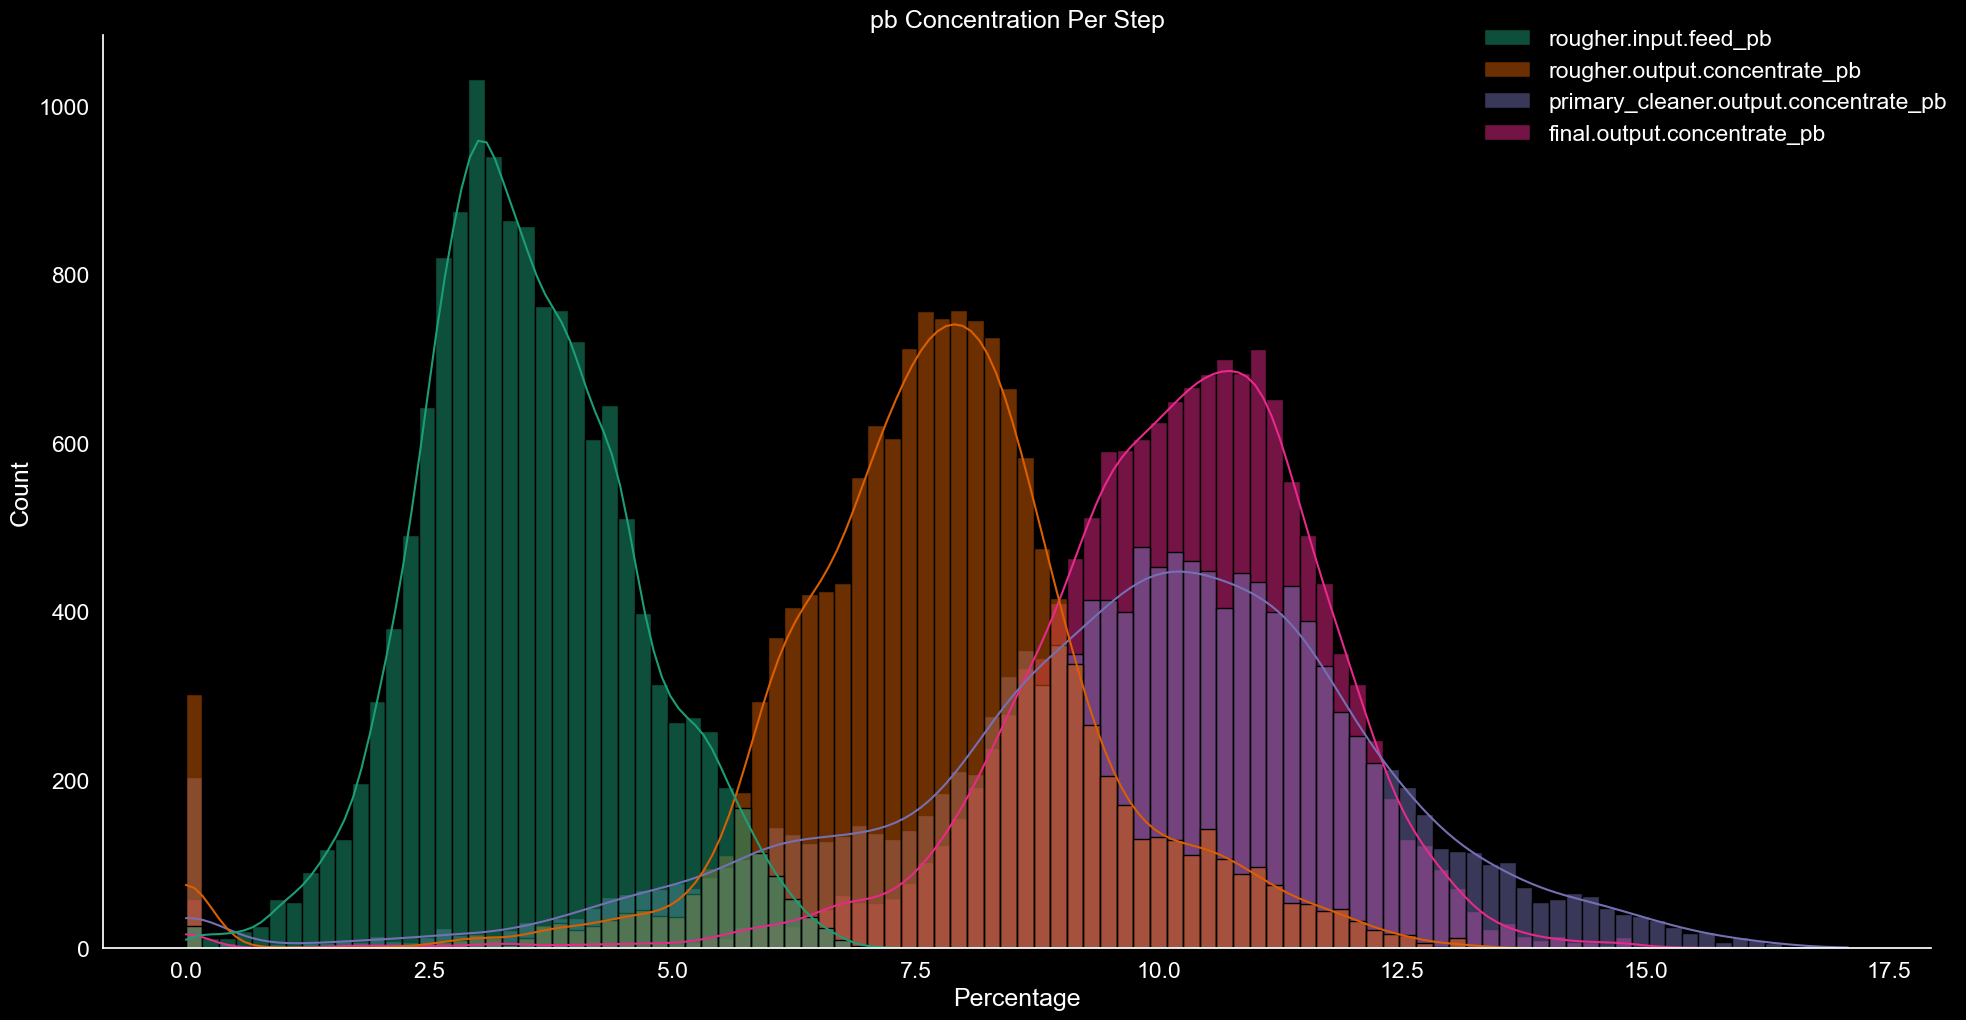

In [39]:
for metal in metals:
    print_hist(metal)

We already see something suspicious in the graphs above, but let's first look at the graph for the *total* concentration of all three metals per step, before we elaborate.

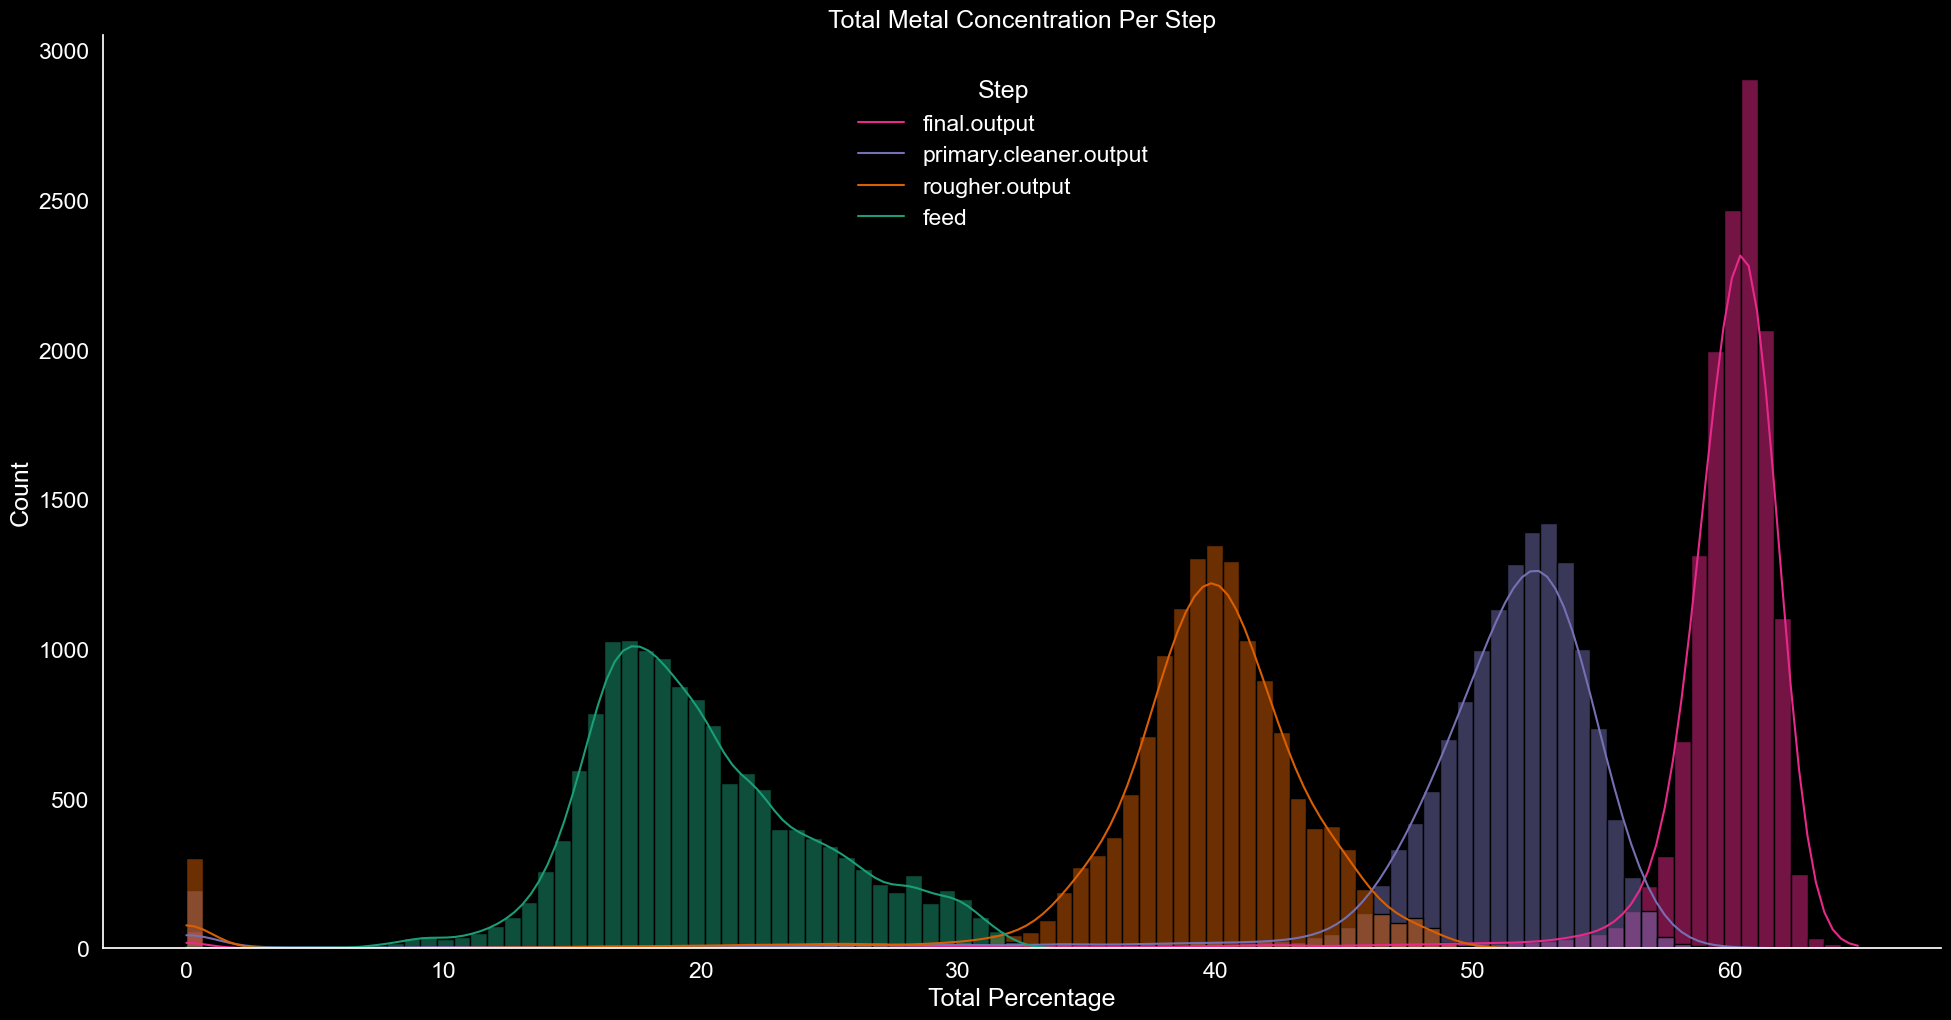

In [40]:
# visualizing the total-concentrations:
totals = [] # this list will contain the four "columns" to be drawn. 
            # these columns are for the visualization only, and will not be added to the dataframe.

for step in step_headers:
    total_metal_conc = 0
    for metal in metals:
        # the brackets below define the exact step and exact metal in question.
        total_metal_conc += gold_recovery_train_new[step+metal] 
    totals.append(total_metal_conc) # adding the result to the `totals` list, as a "column".

# plotting the histogram
ax = sns.displot(totals, kind = 'hist', bins = 100, 
                 kde = True, edgecolor = 'Black', height = 10, aspect = 2, legend = False)
ax.set(title = 'Total Metal Concentration Per Step', xlabel = 'Total Percentage')
ax.add_legend(title = 'Step', labels = ['final.output', 'primary.cleaner.output', 'rougher.output', 'feed'])
sns.move_legend(ax, "upper center", bbox_to_anchor=(0.45, 0.95))

Okay, that was quite a lot of charts. Let's elaborate what we see. Grab some coffee and cookies, there's a lot to talk about here.

Start with the specific metals:

Looking at the first graph, dealing with *gold (Au) concentration* per step - we see exactly what we hoped to see. With each step of the process, the concentration of gold becomes larger and larger. It is distributed somewhere around 6-8% before the process even starts (feed), and goes up to around 45% after the final purification step. We see that the distributions of all four steps have relatively small overlaps. Meaning, the process works as intended - the concentration of gold is increasing with each step. So far, so good.

The next graph, dealing with *silver (Ag) concentration* per step, shows that the concentration of silver is indeed lower after the final purification step, compared to the concentration before the process begins. Interestingly, silver's concentration *increases* after the flotation process, and then starts decreasing with every subsequent purification step. After the `primary_cleaner` step, it is more or less identical to the concentration in the initial feed, but that could be coincidental. 

It is likely that during `flotation`, certain components of the gold ore are removed, but silver remains in the mixture -  therefore its concentration (%) among the remaining components increases. After that, the `primary_cleaner` and `secondary_cleaner` (final step) take care of the silver by removing it by some margin, and as a result its concentration is being lowered after these two steps, to a lower level than the initial concentration. 

The overlaps between the different steps suggest that the silver concentration doesn't change as drastically as does that of gold's with each step, but it still changes, and we can clearly see that the final output has less silver in it than the initial feed has, and that means that the process can still be considered effective (though not perfect) when it comes to removal of silver from the gold ore. The initial distribution of silver's concentratin is around 7.5% (that's the mode value, the distribution is quite heavily skewed to the left), and that number goes down to about 5% at the end of the process, with a slighty smaller skewing to the left.

The third graph, dealing with *lead (Pb) concentration* per step, shows something quite interesting yet slightly unfortunate. Initially, the concentration of lead is about 3% (again - that's just the mode, the distribution is skewed to the left), after `flotation` it is about 8%, and after both purification steps - it is around 11%. Meaning, it only increases with each step (also, note the difference between the `primary_cleaner.output` and `final.output` graphs of this metal). In other words, it remains one of the gold's main metal impurities (more than silver, at least, which goes down after the two purification steps). 

The explanation might be fairly simple - the entire purification process deals with silver and other ore components much better than it deals with lead, so the latter just "sticks" to the gold, and so its *share* (% concentration) is increasing with each step, similarly to the concentration of gold itself, although the gold/lead concentration *ratio* also increases with each step, so we still end up with a higher-quality gold in the end (that is to say, don't let the increasing concentration percentage of lead alarm you).

After we understood all that, let's look at the final graph, dealing with the *total concentration of the three metals* in each step. Here, we see exactly what we wanted and expected to see: with each subsequent step, the three metals (combined) hold a larger share in the gold ore. Since we aren't magically creating these metals out of nothing (if only we could...), the increasing percentages/shares mean that the entire purification process is quite effective at getting rid of other ore components, also known as impurities, also known as "undesirable junk".

As a side note - we also noticed that we have some heavy "tails" in many of the graphs (if not all of them). This simply means that sometimes the process does not yield very typical results - for better or worse. For example, a heavy left tail in the final gold concentration graph means that in that in some cases, an untypically low concentration of gold was obtained, which isn't very good. A heavy right tail in the final silver concentration graph means that in some cases, there was a relatively high concentration of silver at the end product, which isn't very good either. These things can be affected either by the specific properties of the gold-ore itself, and/or the parameters of the process (amounts of additives/reagents, etc.). 

## Anomalies

Last but definitely not least, there is something we must pay attention to. In all of the above graphs, for *every* metal, in *almost every* step of the process - we have a certain amount of `0.0` observations. Meaning, according to these observations, the concentration of either lead, silver, or even gold itself - in any of the relevant steps - is simply zero. This seems very, *very* unlikely, not to mention that it doesn't make much sense. Though it is possible that an occasional gold-ore sample doesn't have any silver/lead impurities in it - it is quite rare, and could be considered an outlier, since we can clearly see that this isn't the typical case.

Also, the fact that we have `0.0` values in the **total concentration** graphs means that for some observations - the concentrations of *all three metals - for one or more steps - is zero*. This is, of course, nonsense.

This is probably some problem with the data. We can only guess, but it might be a simple issue of incorrectly-filled data in the first place (like missing values, which were somehow filled with zeros). We don't know what is going on, and maybe in retrospect we could have changed these 0-values to `NaN` and fill them the same way we did with the real missing values - but we don't know if that would be the right thing to do, since we don't know what caused these zeros.

Either way - whether our assumption is right or wrong, and whether these zeros are genuine observations or not (again, not very likely - who would try to purify a gold-ore containing 0% gold?) - we can at least agree that whatever the cause may be, these observations are *anomalies*, and thus must be removed from the data.

## Dealing With Anomalies
With the anomalies detected - and there is quite a few of them - the question to be asked now is how we deal with them. Naturally, we have two main approaches:

1) Butcher's approach: Remove every observation which has *at least one* `0.0` value in *any* of the features discussed above - regardless of metal and stage. We can count exactly how many "zeros" each feature has (though some observations may only have one feature with a zero value, some may have several "zero-features").

2) Surgical approach: Remove every observation which has a *total metal concentration* of 0 in a specific stage. These are clearly anomalies, either because of error in the data or any other reason.

Of course, the right approach for us might be somewhere between the above two. Let us consider the following two points:

- Our main goal is to build a *predictive model*. Which features will this model have available to it? what is it going to predict? surely, it will not have features like `final.output.conentrate_M` or even `rougher.output.concentrate_M`. Also, many other features, as we have already established, are features we can only know/measure in retrospect, after the purification process took place. 

    In other words - features like `rougher.output.concentrate_M` will NOT be used in our model training at all. Therefore, removing some observations just because they have a rogue "zero value" in one of those features, while having perfectly genuine and useful values in the real *necessary* features - just doesn't seem right. We will have less data to train our model with, and not for a good reason.
    
    It should be noted, however, that removing observations with zero-values in those "other" features is good and important for data *analysis* purposes - but it is not relevant specifically to our model.

    Therefore, conclusion number 1 - we should remove anomalies only if they occur in the `rougher.input.feed_M` feature(s) - we will check for that. The rest are irrelevant for our model training and prediction, and we don't want to lose observations if it has no gain.

- We already agreed that if the *total* concentration of metals is 0 - this is an anomaly/error which must be removed. But, is it the only case worth removing? What if a certain observation has only one "zero value" in one of the `rougher.input.feed_M` feautres (for only one metal)? it is unlikely that an ore sample has only two metals in it, and not all three (even if it's a genuine observation - it is an outlier, not the typical case). This is especially true if an observation has a `rougher.input.feed_au` feature equal to 0. If there was a genuine ore sample which contains no gold, it probably wouldn't end up in our data in the first place!

    Therefore, conclusion number 2 - we should remove any observation which has *at least* one zero value in any of the `rougher.input.feed_M` features. This will leave us only with observations with non-zero concentrations for all three metals.
    
This is indeed somewhere between the two approaches described above, and this is what we will do - for both the *train* and *test* datasets.

In addition, we will also have to check for zeros in our two target variables - `rougher.output.recovery` and `final.output.recovery`, and remove them too from both the `train` and `full` datasets (the latter will be used for evaluating our model). 


In [41]:
"""
For reference, let's see how many zeros there are in the train set, in all metal concentration columns.
In addition, we will check for the same information in the test set. 
However, since only the `rougher.input.feed` features are relevant for the future model, 
we will only remove observations with zeros in the `rougher.input.feed` features, as explained above. 
The others will not be touched.
"""

# counting the amount of zeros in the relevant features of the *train* set:
relevant_columns = [step+metal for step in step_headers for metal in metals] 
print ('Train set:')
for column in relevant_columns:
    print (column, 'column - number of zeros:', (gold_recovery_train_new[column]==0.0).sum())

print ()

# counting the amount of zeros in the relevant features of the *test* set:
test_relevant_columns = ['rougher.input.feed_'+metal for metal in metals]
print ('Test set:')
for column in test_relevant_columns:
    print (column, 'column - number of zeros:', (gold_recovery_test_new[column]==0.0).sum())

Train set:
rougher.input.feed_au column - number of zeros: 0
rougher.input.feed_ag column - number of zeros: 0
rougher.input.feed_pb column - number of zeros: 0
rougher.output.concentrate_au column - number of zeros: 297
rougher.output.concentrate_ag column - number of zeros: 297
rougher.output.concentrate_pb column - number of zeros: 297
primary_cleaner.output.concentrate_au column - number of zeros: 74
primary_cleaner.output.concentrate_ag column - number of zeros: 74
primary_cleaner.output.concentrate_pb column - number of zeros: 79
final.output.concentrate_au column - number of zeros: 58
final.output.concentrate_ag column - number of zeros: 58
final.output.concentrate_pb column - number of zeros: 58

Test set:
rougher.input.feed_au column - number of zeros: 371
rougher.input.feed_ag column - number of zeros: 371
rougher.input.feed_pb column - number of zeros: 371


Luckily, we have NO observations with `0.0` values in the relevant features (feeds) in the training set! so, nothing to remove when it comes to that.

In the test set, however, we have 371 zero-values for each of the relevant features. Let's hope most of them appear within the same observations. Otherwise, we might remove up to ~1100 observations from our dataset.

For curiosity's sake, let's check it out.

In [42]:
# checking for observations with all three metals having zero values, test set.
test_zeros = gold_recovery_test_new[(gold_recovery_test_new['rougher.input.feed_au']==0) & 
                                    (gold_recovery_test_new['rougher.input.feed_ag']==0) &
                                    (gold_recovery_test_new['rougher.input.feed_pb']==0)]

print ('All-zero feed observations in the test set:', len(test_zeros))

All-zero feed observations in the test set: 371


Looks like we're quite lucky - all zeros come in packs of three (occur within the same observations), so this is the best we could have hoped for (all things considered...)

Now let's check for zeros in the *target* variables of the train set (and the full set too). These will have to be removed as well.

In [43]:
# counting the amount of zeros in the target variables of the *train* set:
target_variables = ['rougher.output.recovery', 'final.output.recovery'] 
print ('Train set:')
for column in target_variables:
    print (column, 'target - number of zeros:', (gold_recovery_train_new[column]==0.0).sum())

print ()

# counting the amount of zeros in the target variables of the *full* set:
print ('Full set:')
for column in target_variables:
    print (column, 'target - number of zeros:', (gold_recovery_full_new[column]==0.0).sum())

Train set:
rougher.output.recovery target - number of zeros: 297
final.output.recovery target - number of zeros: 58

Full set:
rougher.output.recovery target - number of zeros: 394
final.output.recovery target - number of zeros: 98


Naturally, we will remove any observation with at least one zero-value target. Our model should be able to predict two non-zero numbers.

This means that there might be some observations in the test set which are irrelevant, because their matching observations in the full set are about to be removed, due to having at least one zero-value target, and therefore we will have nothing to compare these observations' predictions to.

Also, there may or may not be some overlap between observations with "zero targets" and observations with "zero features". 

Enough talk. It's removal time.

In [44]:
# replacing zero-targets with null-values in the training and full datasets:
for column in target_variables:
    gold_recovery_train_new[column].replace({0.0 : np.nan}, inplace = True) 
    gold_recovery_full_new[column].replace({0.0 : np.nan}, inplace = True)
    
for column in test_relevant_columns:
    gold_recovery_test_new[column].replace({0.0 : np.nan}, inplace = True)

# removing observations with null values, without resetting indices.
gold_recovery_train_new.dropna(inplace = True)
gold_recovery_test_new.dropna(inplace = True)
gold_recovery_full_new.dropna(inplace = True)

Zeros removed. By "zeros" - we mean **absolute zeroes, `0.0`**. There is a possibility that some of the columns have very small values such as 0.0001 etc, which are practically zeroes as well, but these remain part of the data. We can always, if so demanded, replace any value below, say, 0.01, to `NaN` and then remove it too. The following cell contains the code needed for that, but it is not used.

In [45]:
#############
"""
# replacing relevant zeros with null-values in all datasets:
for column in test_relevant_columns + target_variables:
    gold_recovery_train_new[column] = gold_recovery_train_new[column].mask(gold_recovery_train_new[column] < 0.01, np.nan)
    gold_recovery_full_new[column] = gold_recovery_full_new[column].mask(gold_recovery_full_new[column] < 0.01, np.nan)
    
for column in test_relevant_columns:
    gold_recovery_test_new[column] = gold_recovery_test_new[column].mask(gold_recovery_test_new[column] < 0.01, np.nan)

# removing observations with null values, without resetting indices.
gold_recovery_train_new.dropna(inplace = True)
gold_recovery_test_new.dropna(inplace = True)
gold_recovery_full_new.dropna(inplace = True)
"""
#############
print ()

For verificaiton, let's check out how the histograms of the `Output Concentrate` features (of each metal) look now, and see if there are any major outliers. These features had a large number of zero-anomalies (as we've seen above), and we want to see how things have changed.

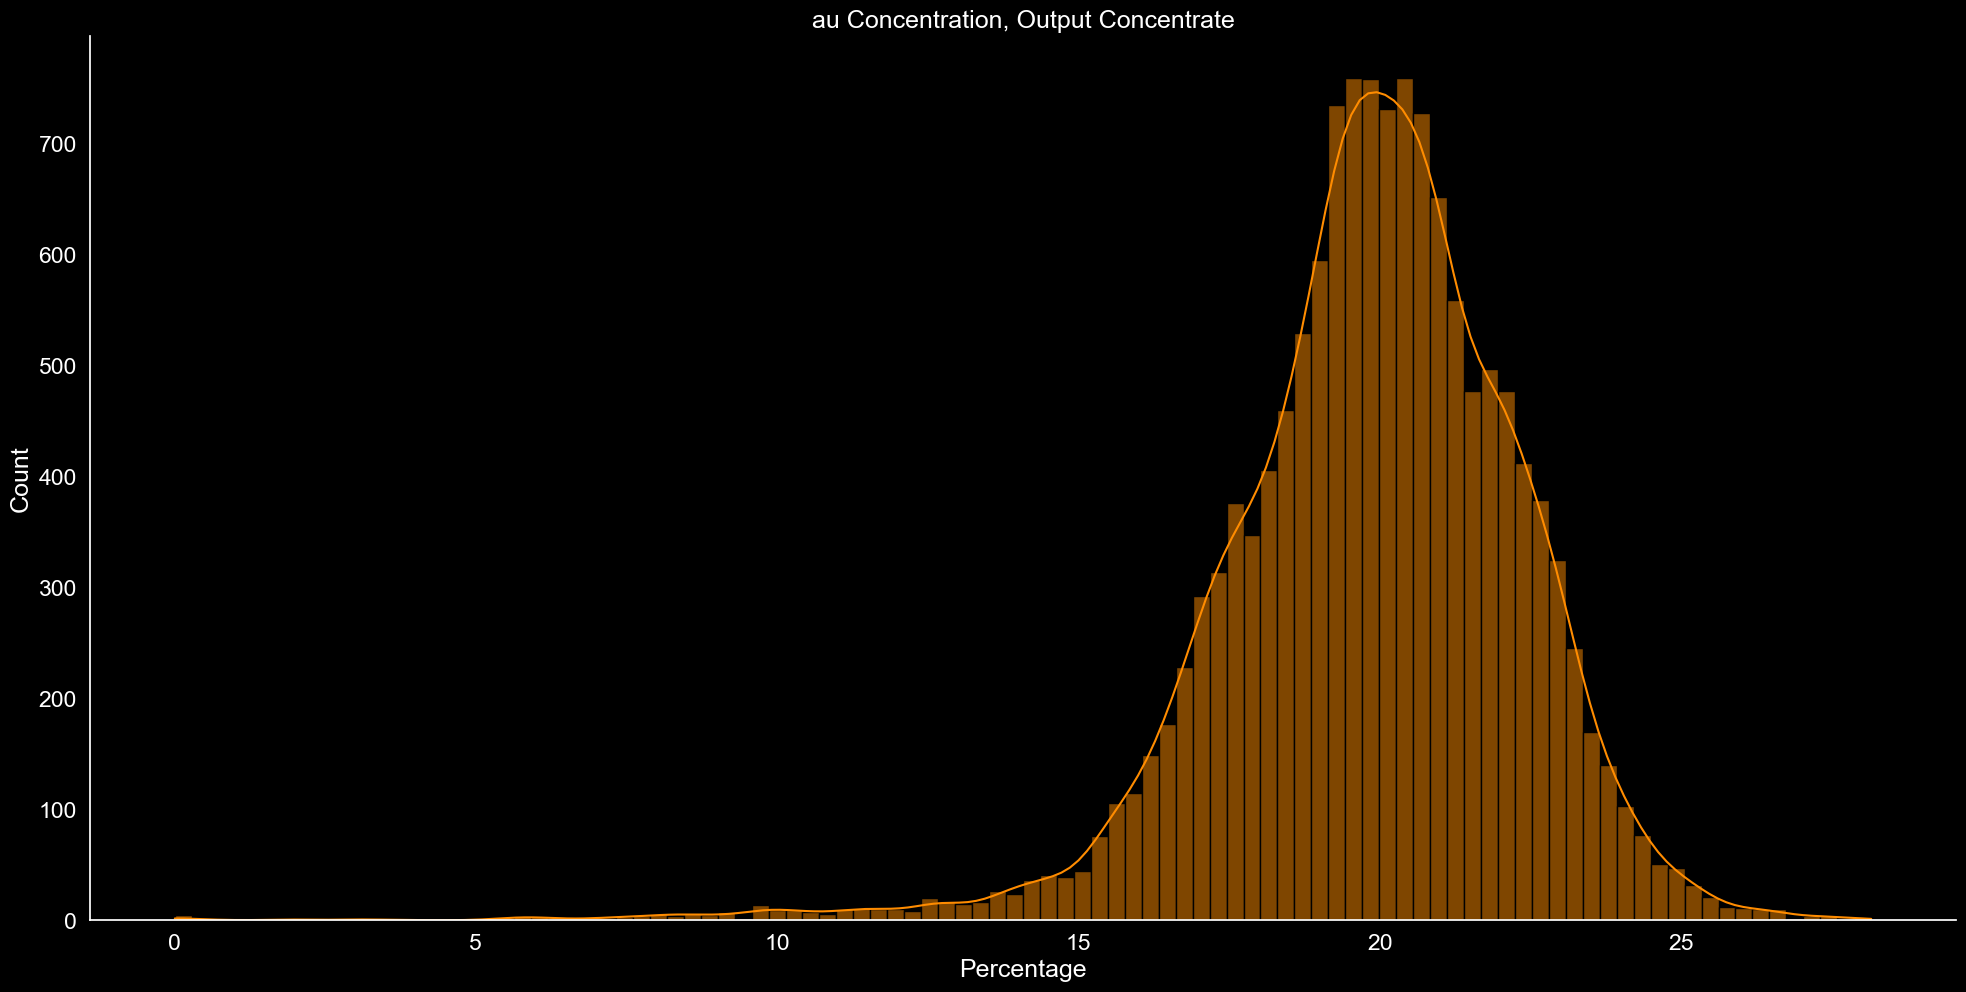

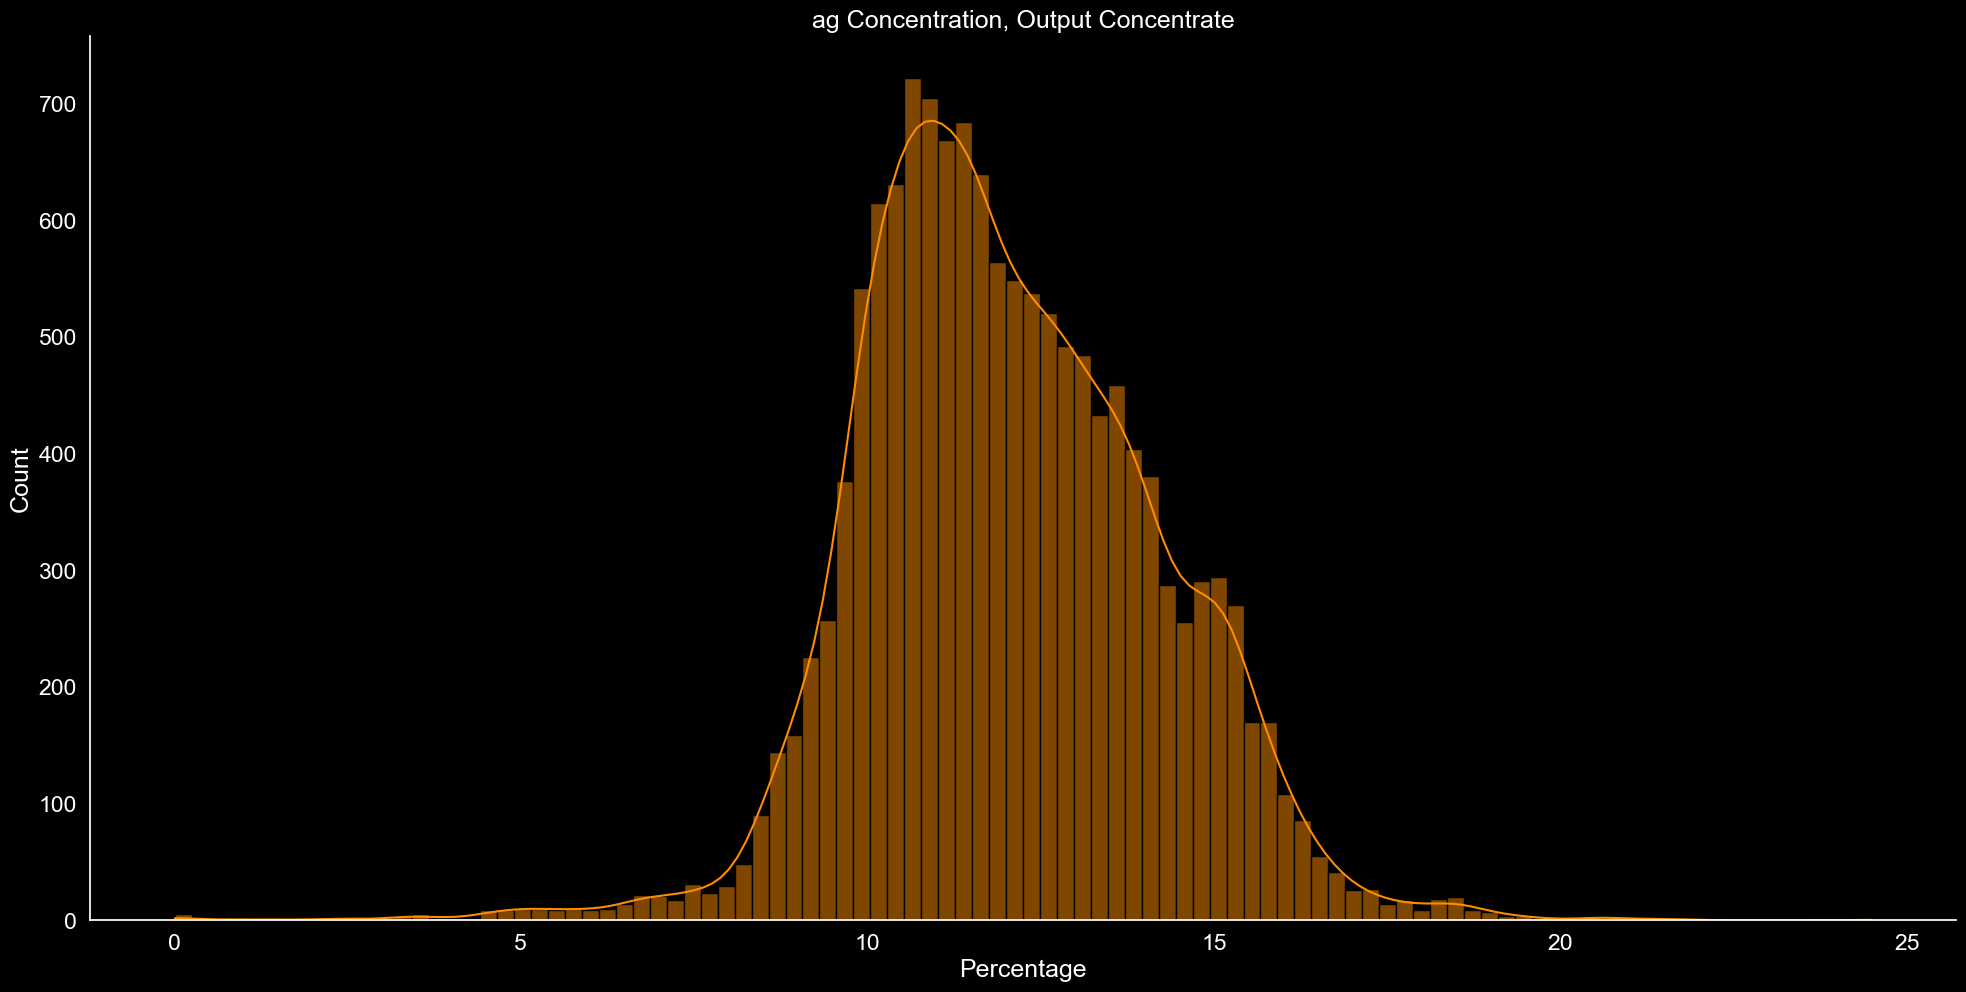

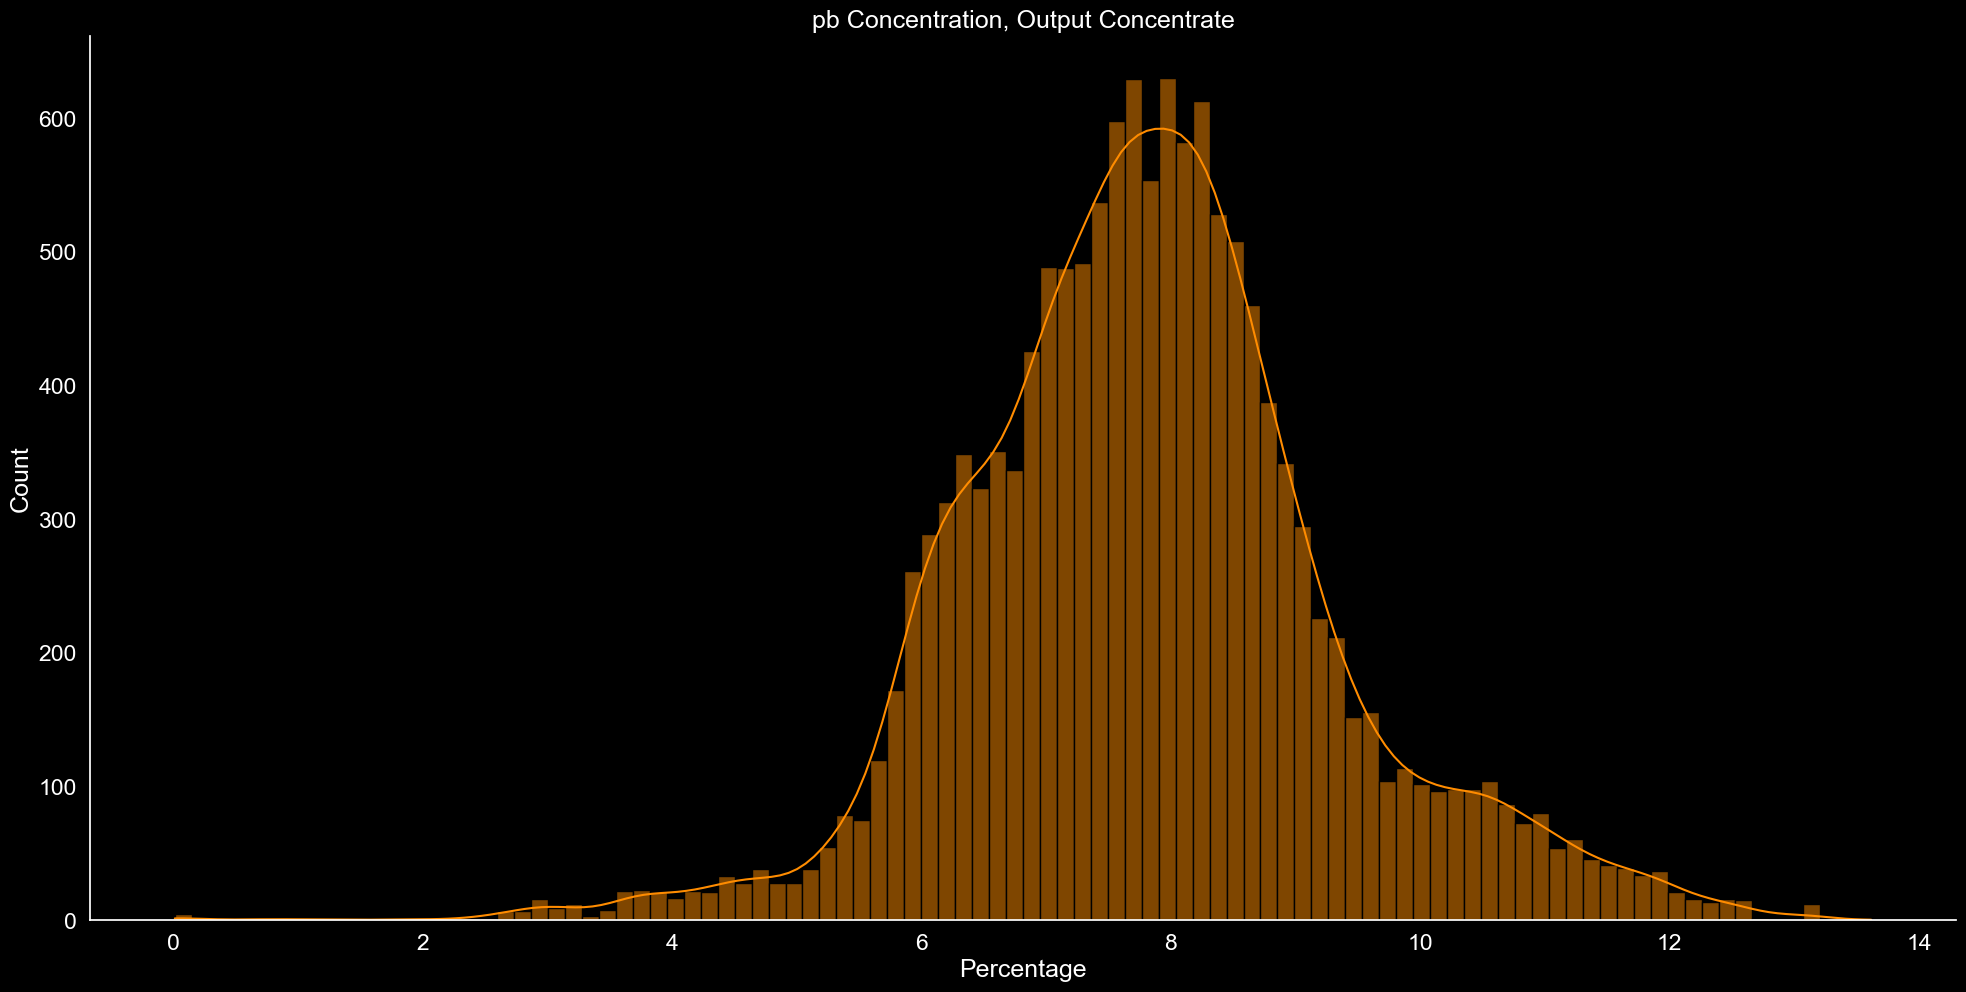

In [46]:
for metal in metals:
    # histogram plot, with kde added to it.
    ax = sns.displot(gold_recovery_train_new['rougher.output.concentrate_'+metal], 
                     kind = 'hist', bins = 100, kde = True, color = 'Darkorange', edgecolor = 'Black', 
                     height = 10, aspect = 2)
    ax.set(title = metal + ' Concentration, Output Concentrate', xlabel = 'Percentage')

Next, we will check what percentages of the datasets remain, after removing the outliers:

In [47]:
print ('Train set after anomalies removal: {:.2%}'.format(len(gold_recovery_train_new) / 
                                                          len(gold_recovery_train_raw)))
print ('Test set after anomalies removal: {:.2%}'.format(len(gold_recovery_test_new) / 
                                                         len(gold_recovery_test_raw)))
print ('Full set after anomalies removal: {:.2%}'.format(len(gold_recovery_full_new) / 
                                                         len(gold_recovery_full_raw)))

Train set after anomalies removal: 81.82%
Test set after anomalies removal: 93.66%
Full set after anomalies removal: 83.42%


We've cut somewhere roughly between 7% to 19% from the three sets. That's quite reasonable.

We can move on.

## Feed Particle Size Comparison
And now, finally, we can compare feed particle sizes in the train and test set. Good thing is we're doing it after we've eliminated anomalies, so we get a more relevant picture.

Also good news is this part will be shorter. We are going to plot the distributions of the `rougher.input.feed_size` and `primary_cleaner.input.feed_size` for both the train and test sets, and see if they match, more or less. If they seem to be roughly the same - it is good. If not, then we have a problem - because that will cause problems with the model.

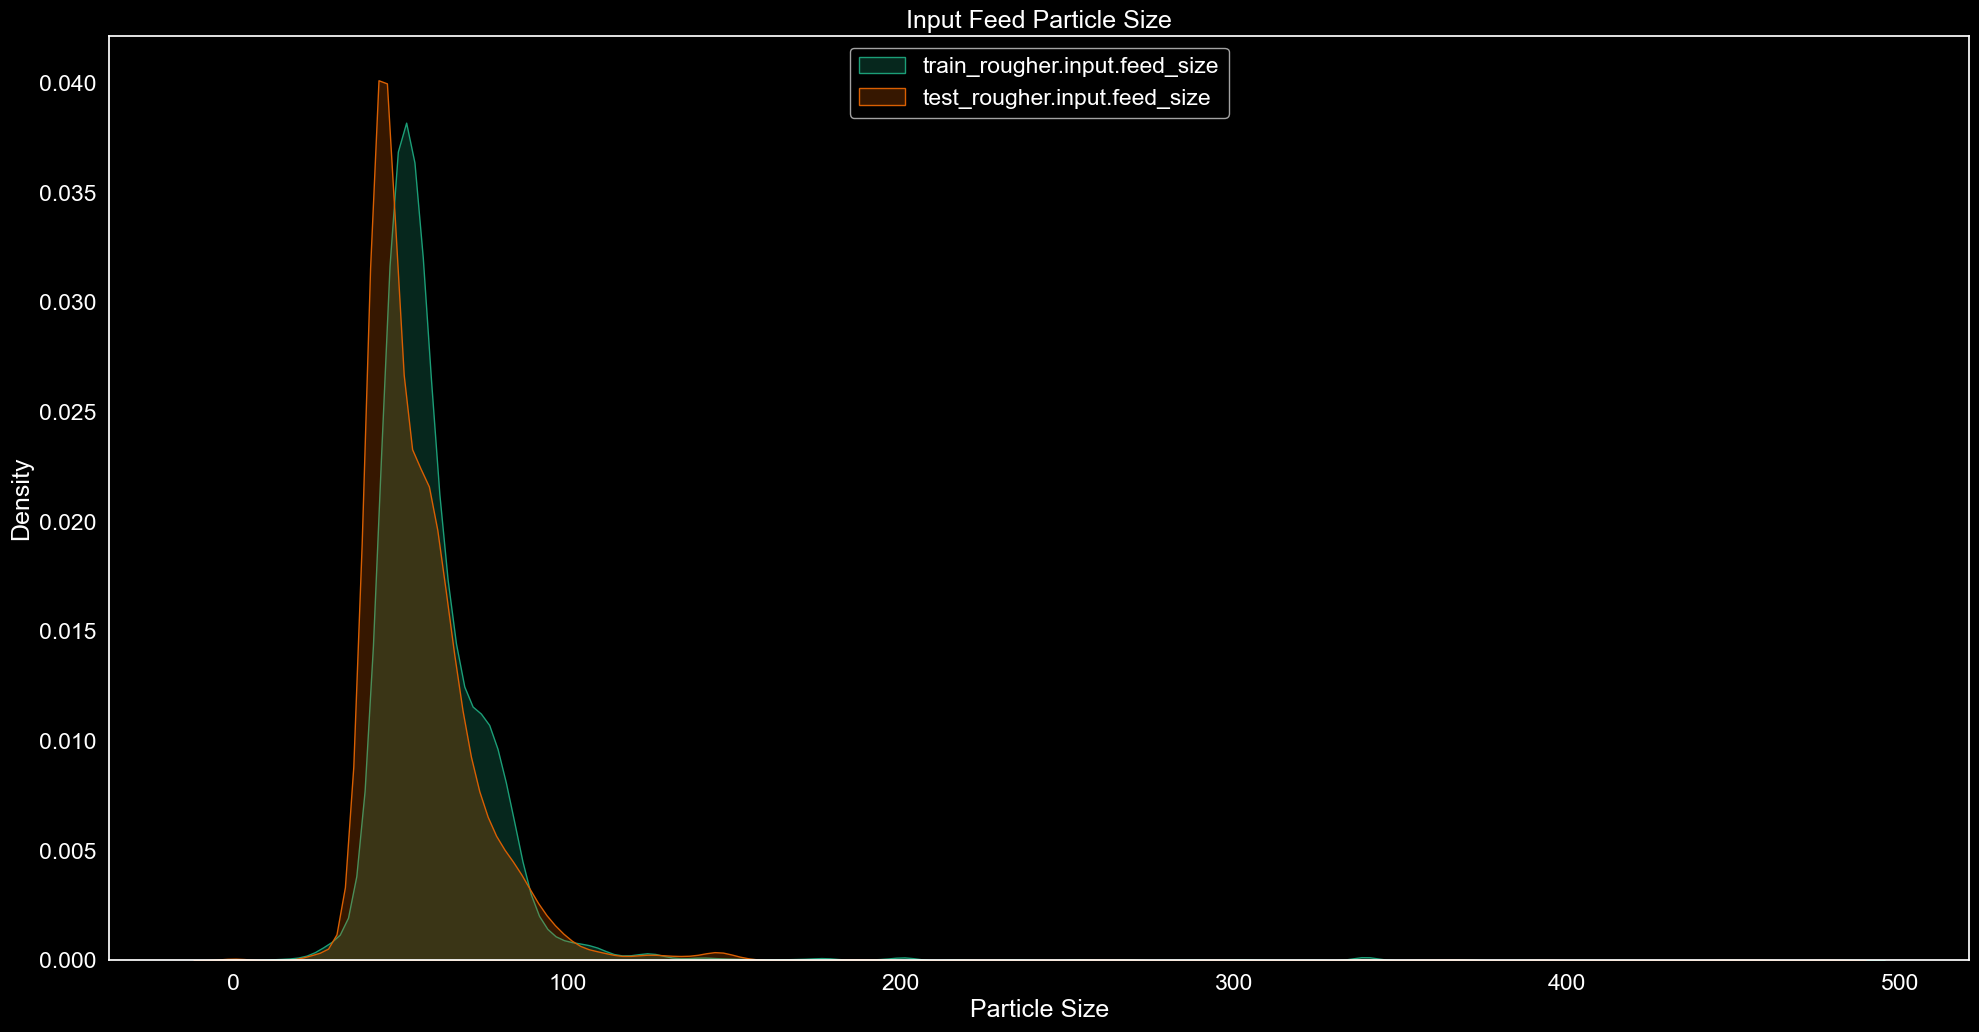

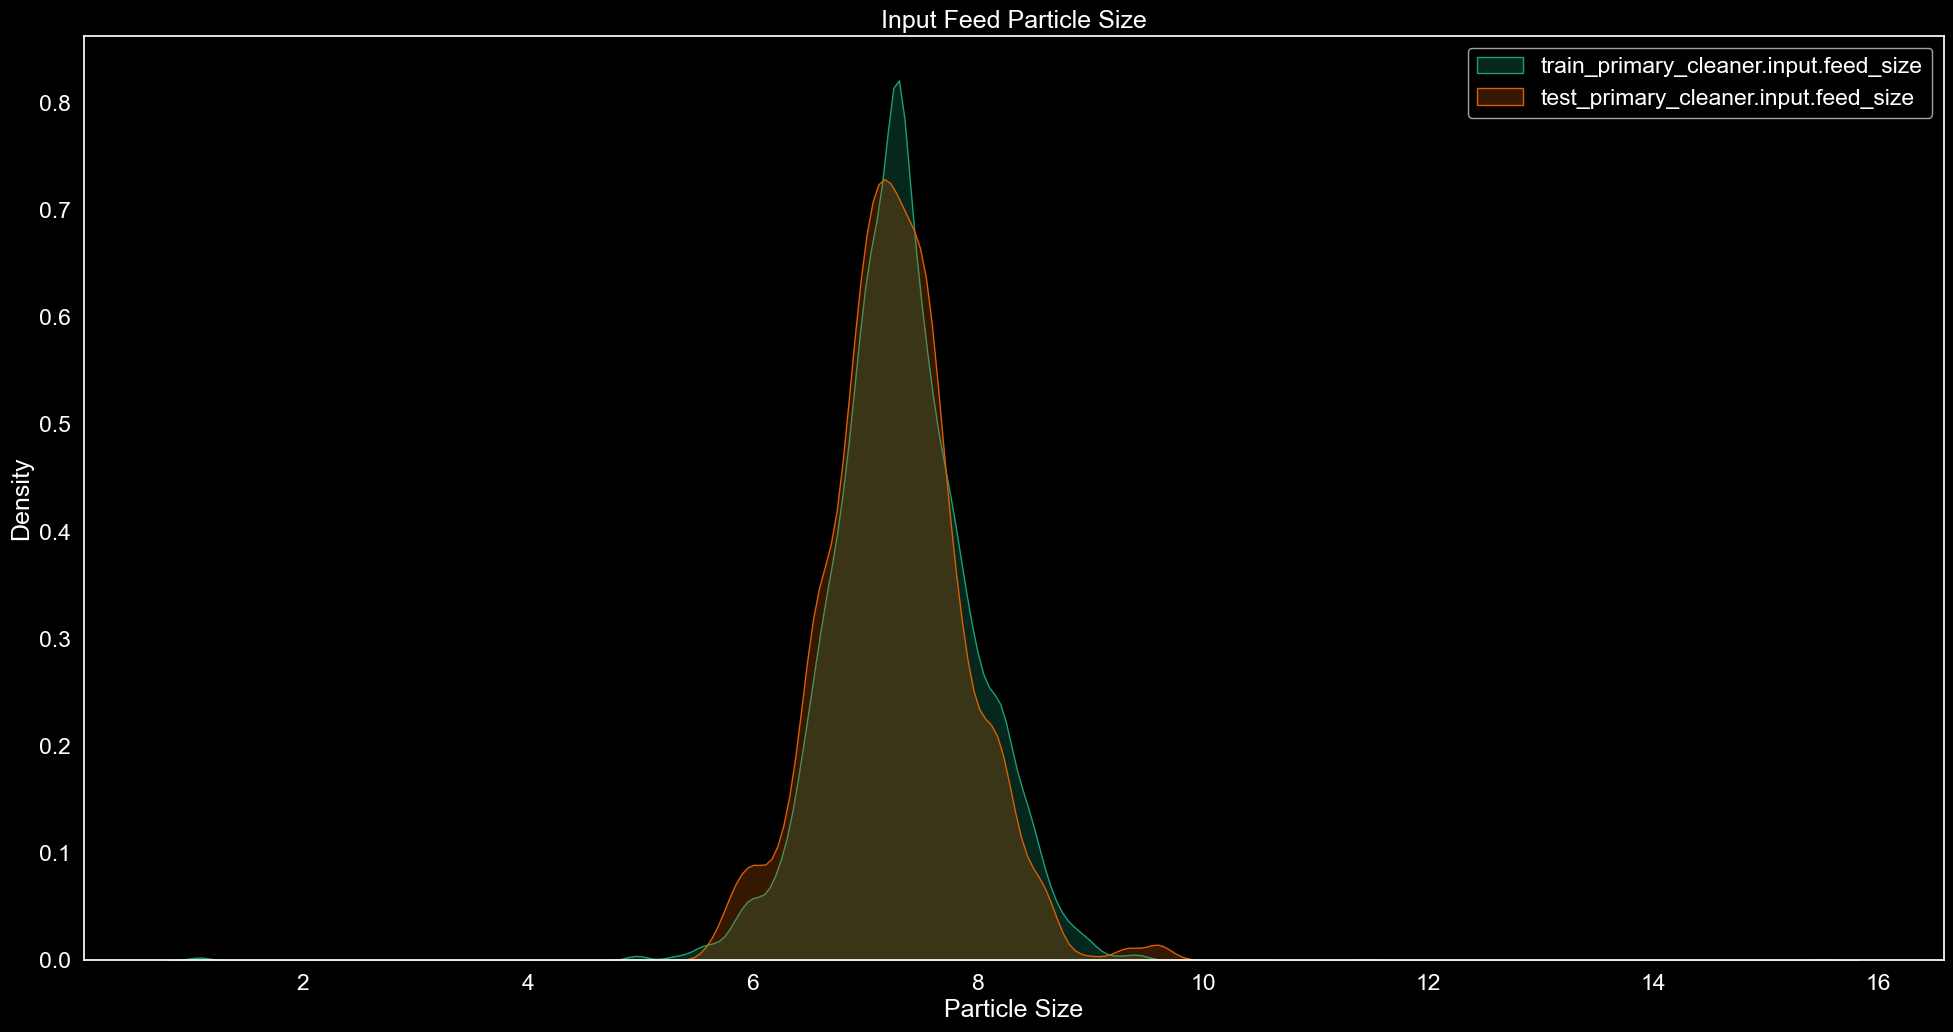

In [48]:
"""
Due to technical reasons of Seaborn library, and in order to get the plots we want, 
we will need to *temporarily rename* the relevant columns in the train and test sets 
(so they won't have identical names), and then use Seaborns `kde` plot. 
After we're done, we will restore the names.

We will not plot histograms, since the test set is quite smaller than the train set, 
and that will result in a plot in which the train set's histogram "engulfs" the one of the test set. 
A `kde` plot will normalize everything and show the true proportions of the distributions we wish to 
compare.
"""

gold_recovery_train_new.rename(columns= 
                               {'rougher.input.feed_size': 'train_rougher.input.feed_size', 
                                'primary_cleaner.input.feed_size': 'train_primary_cleaner.input.feed_size'}, 
                               inplace = True)

gold_recovery_test_new.rename(columns= 
                              {'rougher.input.feed_size': 'test_rougher.input.feed_size', 
                               'primary_cleaner.input.feed_size': 'test_primary_cleaner.input.feed_size'}, 
                              inplace = True)

# plotting rougher input particle size
plt.figure(figsize= (24, 12))
ax = sns.kdeplot(data = gold_recovery_train_new['train_rougher.input.feed_size'], 
                 fill = True, label = 'train_rougher.input.feed_size')
ax = sns.kdeplot(data = gold_recovery_test_new['test_rougher.input.feed_size'], 
                 fill = True, label = 'test_rougher.input.feed_size')
ax.set(title = 'Input Feed Particle Size', xlabel = 'Particle Size')
plt.legend(loc = 'upper center')

# plotting primary cleaner input particle size
plt.figure(figsize= (24, 12))
ax = sns.kdeplot(data = gold_recovery_train_new['train_primary_cleaner.input.feed_size'], 
                 fill = True, label = 'train_primary_cleaner.input.feed_size')
ax = sns.kdeplot(data = gold_recovery_test_new['test_primary_cleaner.input.feed_size'], 
                 fill = True, label = 'test_primary_cleaner.input.feed_size')
ax.set(title = 'Input Feed Particle Size', xlabel = 'Particle Size')
plt.legend(loc = 'upper right')
plt.show()

The two distributions - in each separate step - look pretty much the same. Of course there are some differences, but the main point is there aren't any substantial differences between the test and train sets.

Though this is only a qualitative conclusion, it is good enough for us for the current purposes.

In [49]:
# Renaming the columns back to the original names.

gold_recovery_train_new.rename(columns= {'train_rougher.input.feed_size': 'rougher.input.feed_size', 
                                        'train_primary_cleaner.input.feed_size': 'primary_cleaner.input.feed_size'}, 
                               inplace = True)

gold_recovery_test_new.rename(columns= {'test_rougher.input.feed_size': 'rougher.input.feed_size', 
                                        'test_primary_cleaner.input.feed_size': 'primary_cleaner.input.feed_size'}, 
                              inplace = True)

# Experimenting With Models
We are finished with studying the data, and have finally reached the most important part of the study - building a model. We are dealing with a regression problem (as opposed to classification), so two kinds of models come to mind that can fit: RandomForestRegressor, and LinearRegressor.

The model will need to predict two targets: `rougher.output.recovery` and `final.output.recovery`.

Once these have been predicted, we will use a special metric to evaluate the model. This metric is called `sMAPE`, which stands for `symmetric Mean Absolute Percentage Error`. It is similar to Mean Absolute Error (MAE), but it works with relative values, not absolute ones. Naturally, the better the model - the lower the sMAPE will be, because lower sMAPE means smaller error, which is exactly what we want.

This is how sMAPE is calculated:

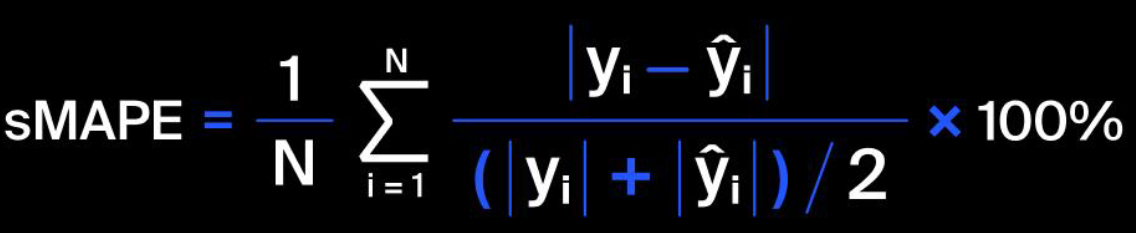

Where:

$y_{i}$ = *real* target value for observation with index 'i'.

$\hat{y_{i}}$ = *predicted* target value for observation with the index 'i'.

N = number of observations.

Of course, we can calculate the sMAPE for either the `rougher.output.recovery` or `final.output.recovery`, so we will have two sMAPE values. Our final metric, therefore, will be a specific combination of the two, given to us courtesy of whoever ordered this model from us.

The final metric is calculated thus:

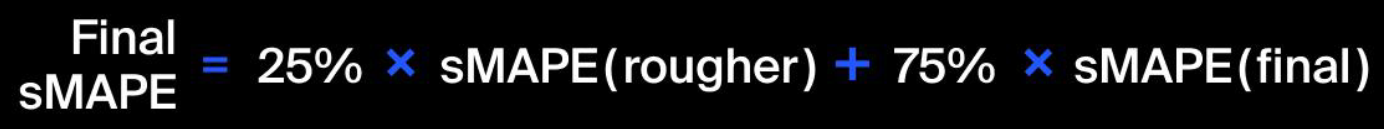

We will write all the necessary functions for calculating these. 

Let's see what are the steps we need to do:

1) Make a subset of the training dataset, containing only the features present in the test set.

2) Prepare our features for the model. While it may not always be necessary, standardizing/scaling our features can never hurt. Therefore, we will standardize all of our features, apply the standardization to our test set as well.

3) Train the model using either of the two model types mentioned above (both will be examined). We will use `GridSearchCV` in order to determine the best hyperparameters (out of a given set) and, by using a 5-fold cross-validation, evaluate our model stabilities. We will see which model gives the overall better metric, and that will be our model of choice.

4) Once we have obtained the model which we think is best, we will use our train data to train it, and then we will test it on the test set, which up until this point will have not been used. In order to evaluate how well did the model fare with the test set, we will have to compare the predictions to *something*. Since the test set does not have any target values, we will need to extract them from the *full* dataset, which we now know is kind of a retrospective dataset, containing all the real result. Merging/joining the test and full datasets - an *inner* join - will provide us with the real target values of the test set, to compare with our predictions.

Start with the functions to calculate sMAPE and final sMAPE.
The function below will calculate the sMAPE for a given series of predictions and their corresponding target values:

In [50]:
# defining a function for sMAPE calculation:
def calc_smape (predictions: np.ndarray, targets: np.ndarray) -> float:
    smape = ((100 * abs(targets - predictions)) / ((abs(targets) + abs(predictions)) / 2)).mean()
    return smape

The predictions which the following function takes as input will come in pairs. Each pair consists of the predictions of `rougher.output.recovery` and `final.output.recovery`. The function below will receive these pairs of predictions (and targets), and for each type of output (`rougher` or `final`) will take the corresponding value, calculate the corresponding sMAPE (using the function above), and finally calculate and return the `final smape` value.

In [51]:
# defining a function for final sMAPE calculation:
def calc_final_smape (predictions: np.ndarray, targets: np.ndarray) -> float:
    
    # the first column constains to the rougher output recovery.
    rougher_output_smape = calc_smape(predictions[:, 0], targets[:, 0])
    
    # the second column belongs to the final output recovery.
    final_output_smape = calc_smape(predictions[:, 1], targets[:, 1])
    
    final_smape = 0.25 * rougher_output_smape + 0.75 * final_output_smape
    return final_smape

For our cross-validation to come, we will need the `final_smape` to be our score. Since we wish the metric to be as low as possible, we will set the `greater_is_better` parameter to `False`.

In [52]:
smape_score = make_scorer(calc_final_smape, greater_is_better = False)

Next, we will make the training features and training target sets:

In [53]:
relevant_features = [col for col in gold_recovery_test_new.columns if col != 'date']
targets = ['rougher.output.recovery', 'final.output.recovery']

In [54]:
features_train = gold_recovery_train_new[relevant_features]
target_train = gold_recovery_train_new[targets]
# turning the targets to an array. Otherwise, it won't be compatible with the predictions.
target_train = target_train.to_numpy()

Now we will attach the target values of the test set from the full set, by means of an inner merge.
Since we have removed "zero-targets" from the full dataset earlier, some observations in the test set have no matching observation in the test set. These will be left out of the merged test set.

In [55]:
merged_test_set = gold_recovery_test_new.merge(gold_recovery_full_new[['date', 
                                                                       'rougher.output.recovery', 
                                                                       'final.output.recovery']], 
                                               how = 'inner', on = 'date')

In [56]:
# doing the same as we did with the training dataset
features_test = merged_test_set[relevant_features]
target_test = merged_test_set[targets]
target_test = target_test.to_numpy()

Training and test sets ready in terms of their features. Time to build some models!

## RandomForestRegressor
First, we will need to define a pipeline which will take care of the standardization for us. That is, in each CV-fold (reminder - there will be five such folds), the scaler will be fit only on the current fold's training subset (80% of the data), and applied on the fold's validation set (the remaining 20%). This will prevent undesired data-leakage within the process.

Second, we will define specific hyperparameter values for the `GridSearchCV` to loop through, searching for the optimal combination which yields the best sMAPE score. We are not going to go too crazy with this - we will only experiment with `n_estimators` and `depth`.

In [57]:
set_config(print_changed_only = False)

# initializing the model
model = RandomForestRegressor(random_state = 117)

# initializing the scaler
scaler = StandardScaler()

# defining the pipe
pipe = Pipeline([('scaler', StandardScaler()), ('RFR', model)])

In [58]:
# depths to try
depthlist = list(range( 5, 26, 5)) 
depthlist.insert(0, None)          
depthlist      

[None, 5, 10, 15, 20, 25]

In [59]:
# n_estimators to try:
estimators = list(range(10, 51, 10))
estimators

[10, 20, 30, 40, 50]

Let's see what's the best Random Forest we can get!

In [60]:
param_grid = {
    'RFR__n_estimators' : estimators, 
    'RFR__max_depth' : depthlist 
}

search = GridSearchCV(pipe, param_grid, cv = 5, n_jobs=-1, scoring = smape_score)
search.fit(features_train, target_train)

# printing the best parameters
print(search.best_params_)

# printing the best sMAPE score
print('{:.2f}%'.format(abs(search.best_score_)))

{'RFR__max_depth': 5, 'RFR__n_estimators': 30}
9.16%


The best RF model has achieved a sMAPE score of 9.16%. However, we think we can improve it even further, without changing any more hyperparameters.

There is something we have to take into account here. During cross validation (hereafter CV), the training data is split into training and validation sets. A good guess would be that the dataset is divided into 5 blocks (since it's a 5-fold CV) where the first 20% of observations are block 1, the next 20% of observations are block 2 and so on. Every iteration, a different block serves as the validation set, and the rest serve as the training set. 

The problem is, we already know our data is *sequential*. There is a significance to the order the observations are listed, and that could adversely affect the CV results, since each block of data may have some unique characteristics to it, which are influenced by the date/time those observations were recorded. 

But, do we really need to keep the training observations in their original order?

Up until now we needed to keep the data's original sequence in order to fill missing values etc., but now that we've come to the stage of model-training, we're not even using the `date` column anymore, and therefore we don't need the data to retain its original order. To our understanding - the model should, at the very end, receive a bunch of parameters from the end-user, and return what it thinks will be the rougher/final recovery of gold. *Sequence may have nothing to do with it.*

Therefore, let's try shuffling the features and targets (using the same `random_state`), and re-run our Grid-Search, and see if we get a better result.

In [61]:
# shuffling the data
features_train = shuffle(features_train, random_state = 117)
target_train = shuffle(target_train, random_state = 117)

And now let's see how the results change, using the exact same model as before.

In [62]:
param_grid = {
    'RFR__n_estimators' : estimators, 
    'RFR__max_depth' : depthlist 
}

search = GridSearchCV(pipe, param_grid, cv = 5, n_jobs=-1, scoring = smape_score)
search.fit(features_train, target_train)

# printing the best parameters
print(search.best_params_)

# printing the best sMAPE score
print('{:.2f}%'.format(abs(search.best_score_)))

{'RFR__max_depth': None, 'RFR__n_estimators': 50}
4.88%


Now that's much more like it. a 4.88% error is a lot more acceptable. This strengthens our theory about the sequentiality of the data harming the model's performance. While we did need its natural order to fill missing values, we are not dealing with a time-series problem, therefore the original order does not make sense when it comes to model training.

## Linear Regression
Now that we have finished with `RandomForestRegressor`, time to move on to `LinearRegression` and see how it fares.

In [63]:
# initializing the model
model = LinearRegression()

# defining the pipe
pipe = Pipeline([('scaler', StandardScaler()), ('LR', model)])

Well, this one will be quick. LR does not have any "real" (useful) hyperparameters - `copy_x` for example just determines if the model copies the data or not, and `normalize` just determines if the model applies normalization to the data or not. Let us not forget - we did normalization ourselves, so it's redundant. Therefore, we will use a simple 5-fold CV for this model, without changing anything, and see:

1) what is the score for each fold of the CV - we want to make sure all of them are close to each other. That will show us how stable our model is.

2) What the mean score is. We will use it to compare to the RF model above.

In [64]:
scores = cross_val_score(pipe, features_train, target_train, cv=5, scoring = smape_score)
print (abs(scores))
print ('{:.2f}%'.format(abs(scores.mean())))

[7.53169914 7.1463583  7.34850995 7.24058698 7.09646184]
7.27%


The above model is slightly worse than our best RF model. Not by much, but still the RF was superior. It's quite possible that LR is simply not the right model for this task, for whatever reason.

Either way, we now have a model of choice: RandomForestRegressor, with a `max_depth` of `None`, and `n_estimators` of 50.

# Testing the Model

In [65]:
model = RandomForestRegressor(random_state = 117, n_estimators = 50, max_depth = None, n_jobs = -1)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=117, verbose=0, warm_start=False)

Now we need to apply the `StandardScaler()` to our train set and apply it on the test set as well.

In [66]:
scaler.fit(features_train[relevant_features])
features_train[relevant_features] = scaler.transform(features_train[relevant_features])
features_test[relevant_features] = scaler.transform(features_test[relevant_features])

Excellent. Now, we are going to use the entire training set to train this model, and use it to predict the targets of the test set. Once we have the predictions, we will check what the final sMAPE score we achieve is.

In [67]:
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)

In [68]:
final_result = calc_final_smape (predictions_test, target_test)

print ('{:.2f}%'.format(final_result))

7.99%


That's our final result. The model's final sMAPE metric, when being used on the test set, is roughly 8.0%. This isn't too bad, but one last question remains - how does it compare to a dummy model?

We will have to check that. Let's assume we have a dummy model which predicts the same target values all the time. That would be the mean values of `rougher.output.recovery` and `final.output.recovery`, for every observation. What would be the sMAPE in that case? Will it be better or worse than the model above?

# Sanity Check

Let's see what the mean values of the targets in the training dataset are:

In [69]:
print (target_train[:,0].mean()) # mean value of `rougher.output.recovery`
print (target_train[:,1].mean()) # mean value of `final.output.recovery`

84.50500475220969
66.82963741869789


Now let's create a dummy model which always predicts these mean values, when given the test features:

In [70]:
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(features_train, target_train)
fake_predictions = dummy_model.predict(features_test)
fake_predictions

array([[84.50500475, 66.82963742],
       [84.50500475, 66.82963742],
       [84.50500475, 66.82963742],
       ...,
       [84.50500475, 66.82963742],
       [84.50500475, 66.82963742],
       [84.50500475, 66.82963742]])

We have our fake predictions. Here goes nothing:

In [71]:
dummy_result = calc_final_smape (fake_predictions, target_test)

print ('{:.2f}%'.format(dummy_result))

7.77%


Well...**$h!t**.

This is very disappointing. A dummy model would have done a better job than our real model! Not by a huge margin, but that hurts nonetheless. This could mean a few things:

1) We simply haven't found the right model for us;

2) We don't have enough data to train our model with, or maybe it just isn't good enough, in order to make better predictions;

3) This problem can't be solved by machine learning (that's a bit extreme, but nonetheless an option).

4) The given train/test split was just not ideal. Maybe if we just took the full dataset (after doing all of our manipulations on it) and then split it to train/test in a randomized - not sequential - fashion, we would have got a better result. We already saw that the natural ordering of the data adversly affects the model's performance. Maybe that's the case here too.

5) The devil was involved (see project's name!), and made us fail.

And so, on this very discouraging note, our study is officially concluded. We will never look at gold the same way again...and we apologize for not being able to provide you with better results!